In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)

In [2]:
cellType = "10mM2DG" #RAS PC3 DITNC1 SC P 0.75mM2DG 2mM2DG 5mM2DG 10mM2DG
numCores = 10
numBestFitIters = 100
numMonteCarloIters = 500
numMonteCarloIters_downsample = 200

In [3]:
concentration = pd.read_csv("../data/concentrations.csv",index_col=0)
excret = pd.read_csv("../data/excretion_flux.csv",index_col=0)
lacEx = excret.at[cellType,"lactate_excretion_fmol_cell_min"]
gluUp = excret.at[cellType,"glucose_uptake_fmol_cell_min"]
concs = {met:val for met,val in zip(concentration.columns.values,concentration.loc[cellType,:].values)}
print(concs)
print(lacEx,gluUp)

{'NAD(H)': 0.7646586470000001, 'Malate': 0.39591995799999996, 'G3P': 0.166969854, 'Lactate': 14.96075884}
3.24 14.18


In [4]:
def clip(val,max=1.0,min=0.0):
    if val > max:
        return max
    if val < min:
        return min
    return val


def fitModel(p,t,conc,exc,gluUp,init=100,ci = 95,initialParams = np.random.rand(5,1),numIts = 100,numPoints = 3,numCores=4):
    ts = list(set(t))
    ts.sort()
    groupedData = {tt:{s:[] for s in range(len(p[0]))} for tt in ts}
    
    for row in range(len(p)):
      for col in range(len(p[row])):
        groupedData[t[row]][col].append(p[row,col])
    df = 2
    randomP = {tt:{s:[] for s in range(len(p[0]))} for tt in ts}
    pool = Pool(numCores,maxtasksperchild=1)

    q = Queue()
    
    fluxes = []
    processes = []
    
    args = []
    for x in range(numIts):
        pr = Process(target=findFlux,args = (np.array([[clip(stats.t(df,np.mean(groupedData[tt][s]),
                   np.std(groupedData[tt][s])).rvs(size=1)[0]) for s in range(len(p[0]))] for tt in t]),
                   t,conc,exc,gluUp,initialParams,q))
        if not q.empty():
           fluxes.append(q.get())
           processes = [x for x in processes if x.is_alive()]
        while(len(processes) >= numCores):
           if not q.empty():
               fluxes.append(q.get())
           processes = [x for x in processes if x.is_alive()]
           if len(processes) >= numCores:
                processes[0].join(timeout=15)
                processes[0].terminate()
        processes.append(pr)
        pr.start()
        print(x)
    for x in processes:
       while not q.empty():
           fluxes.append(q.get())
       x.join(timeout=15)
       
    while not q.empty():
       fluxes.append(q.get())
    
    [p.terminate() for p in processes]
    
    fluxes = [x for x in fluxes if type(x) != type(-1)]

    fluxes = np.array(fluxes)
    flux = [np.mean(x) for x in fluxes.transpose()]

    intervalParams = []
    interval = []
    for x in range(3):
      temp = list(fluxes[:,x])
      maxi = np.percentile(temp,100-((100-ci)/2),interpolation="nearest")
      mini = np.percentile(temp,(100-ci)/2,interpolation="nearest")
      indOfMax = temp.index(maxi)
      indOfMin = temp.index(mini)
      intervalParams.append([fluxes[indOfMin,:],fluxes[indOfMax,:]])
      interval.append([mini,maxi]) 
      

    return init,flux,interval,intervalParams,fluxes




In [5]:
data = pd.read_csv("../data/" + cellType + "/" + cellType+".csv").to_numpy()
t = data[:,0]
p = data[:,(8,2,4,6)]
p = p/100
print(p)
conc = [concs["Malate"],concs["G3P"],concs["Lactate"],concs["NAD(H)"]]


[[1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [0.93821877 0.98705582 0.95048375 0.99789833]
 [0.91213633 0.98761047 0.95272991 0.99778054]
 [0.95565965 0.98431043 0.94299685 0.99659518]
 [0.81212286 0.960118   0.766593   0.9838658 ]
 [0.7740889  0.95616865 0.75977537 0.9899761 ]
 [0.7740889  0.96091307 0.77821392 0.99259989]
 [0.75813436 0.94288206 0.66265462 0.99210233]
 [0.7740889  0.95110115 0.6697226  0.99345109]
 [0.75418071 0.94045444 0.66149472 0.98969215]]


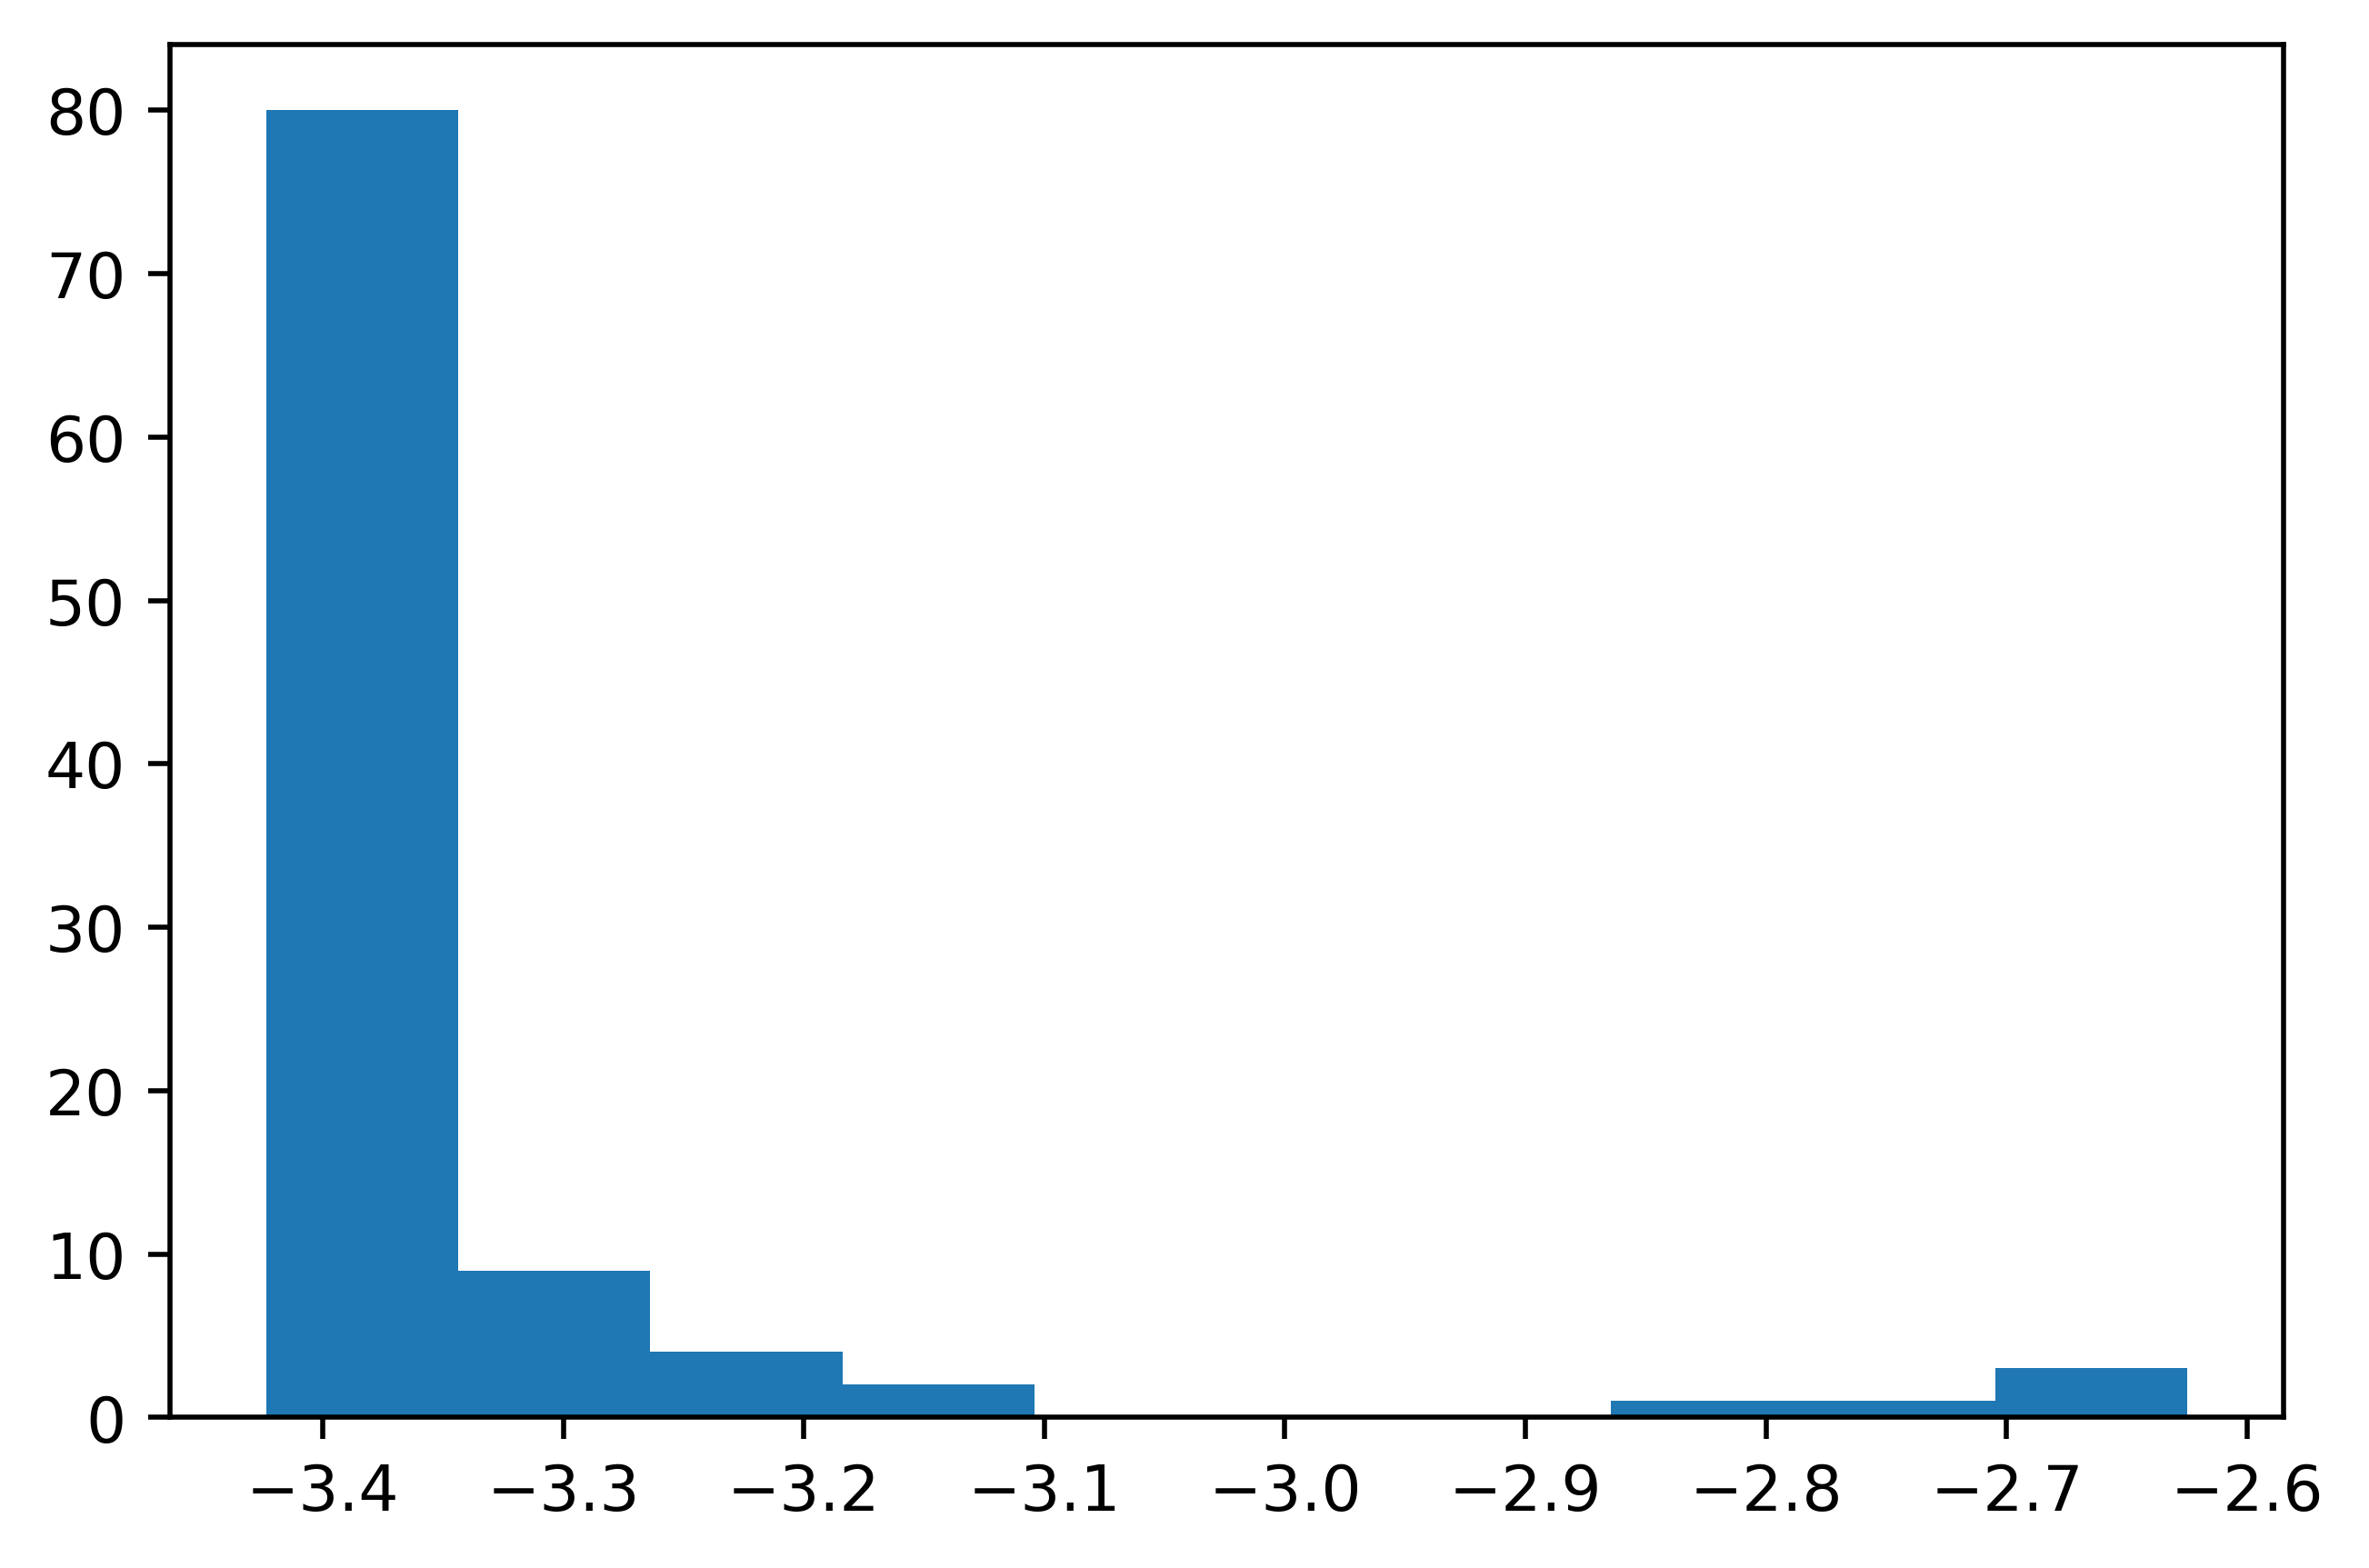

In [6]:
if __name__ == '__main__':
    args = [[p,t,conc,lacEx,gluUp,np.random.rand(4,1)] for _ in range(numBestFitIters)]
    startingParams = Pool(numCores).starmap(findFlux,args)
    startingParams = [x for x in startingParams if type(x) != type(-1)]
    plt.hist([[np.log10(x[-1]) for x in startingParams]])
    startingParams.sort(key=lambda x: x[-1])
    plt.show()


In [7]:
bestParams = startingParams[0]
print(bestParams)

[ 5.05725361e-01  9.60182454e-01  1.36086851e-01  2.17769148e+00
  3.10391315e+00  1.30959843e-01  3.19863439e-01 -1.22238562e-01
  6.84082087e-01  3.77082144e-04]


In [8]:
bestParams = startingParams[0]
print(bestParams)
if __name__ == '__main__':
    [init,flux,interval,intervalParams,allFluxes] = fitModel(p,t,conc,lacEx,gluUp,
                   initialParams = [bestParams[0],bestParams[1],bestParams[3],bestParams[5]],numIts = numMonteCarloIters,numCores=numCores)
pkl.dump([allFluxes,bestParams],open("../data/" + str(cellType) + "/" + cellType + ".pkl","wb"))

#[allFluxes,bestParams] = pkl.load(open( cellType + ".pkl","rb"))

[interval,intervalParams,allFluxes] = removeBadSol(allFluxes,ci=95,cutoff=2*bestParams[-1],target=numMonteCarloIters_downsample)



[ 5.05725361e-01  9.60182454e-01  1.36086851e-01  2.17769148e+00
  3.10391315e+00  1.30959843e-01  3.19863439e-01 -1.22238562e-01
  6.84082087e-01  3.77082144e-04]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
23

In [9]:
t_t = np.linspace(0,3*max(t),100)
print(bestParams)
"""
[ 8.07073753e-01  5.64266110e-02  5.61447969e-01  9.84776390e-01
  7.34287184e-01  2.11647608e-01 -1.39103625e-01  6.54110283e-01
  8.11174172e-04]

"""


[ 5.05725361e-01  9.60182454e-01  1.36086851e-01  2.17769148e+00
  3.10391315e+00  1.30959843e-01  3.19863439e-01 -1.22238562e-01
  6.84082087e-01  3.77082144e-04]


'\n[ 8.07073753e-01  5.64266110e-02  5.61447969e-01  9.84776390e-01\n  7.34287184e-01  2.11647608e-01 -1.39103625e-01  6.54110283e-01\n  8.11174172e-04]\n\n'

In [10]:
outdict = {"MDH":{"bestFit":bestParams[0],"LB":interval[0][0],"UB":interval[0][1]},
           "GPD":{"bestFit":bestParams[1],"LB":interval[1][0],"UB":interval[1][1]},
           "LDH":{"bestFit":bestParams[2],"LB":interval[2][0],"UB":interval[2][1]},
          "SSE":{"bestFit":bestParams[-1],"LB":None,"UB":None}}
outdict = pd.DataFrame.from_dict(outdict,orient="index")
outdict.to_csv("../data/" + cellType + "/" + cellType + "_fluxes.csv")
outdict

,bestFit,LB,UB
MDH,0.505725,0.499961,0.515092
GPD,0.960182,0.957401,0.960842
LDH,0.136087,0.027928,0.186979
SSE,0.000377,NaN,NaN


In [11]:
predictedL = integrateLabelingModel(t_t,bestParams[:3],np.append(conc[:-1],bestParams[5:6]),bestParams[6:-1],bestParams[3:5])


[array([ 4.99961083e-01,  9.59781361e-01,  8.88645554e-02,  2.17900408e+00,
        3.15113544e+00,  1.32038906e-01,  3.13654501e-01, -1.24132997e-01,
        6.87322556e-01,  5.05931595e-04]), array([ 5.15092278e-01,  9.59750052e-01,  1.14605510e-01,  2.17549353e+00,
        3.12539449e+00,  1.32049147e-01,  3.24794720e-01, -1.13768805e-01,
        6.80042734e-01,  3.61522468e-04])]
[array([ 5.06703790e-01,  9.57401130e-01,  7.86893912e-02,  2.17729814e+00,
        3.16131061e+00,  1.38544209e-01,  3.05005065e-01, -1.31275000e-01,
        6.92552752e-01,  4.05908781e-04]), array([ 5.09053490e-01,  9.60841527e-01,  1.27970376e-01,  2.17696289e+00,
        3.11202962e+00,  1.29105913e-01,  3.26112675e-01, -1.08601885e-01,
        6.79683607e-01,  4.62848564e-04])]
[array([ 5.06306787e-01,  9.59953739e-01,  2.79275973e-02,  2.17754957e+00,
        3.21207240e+00,  1.31549232e-01,  3.34090933e-01, -1.25320512e-01,
        6.80624801e-01,  3.83684916e-04]), array([ 5.05988506e-01,  9.60627

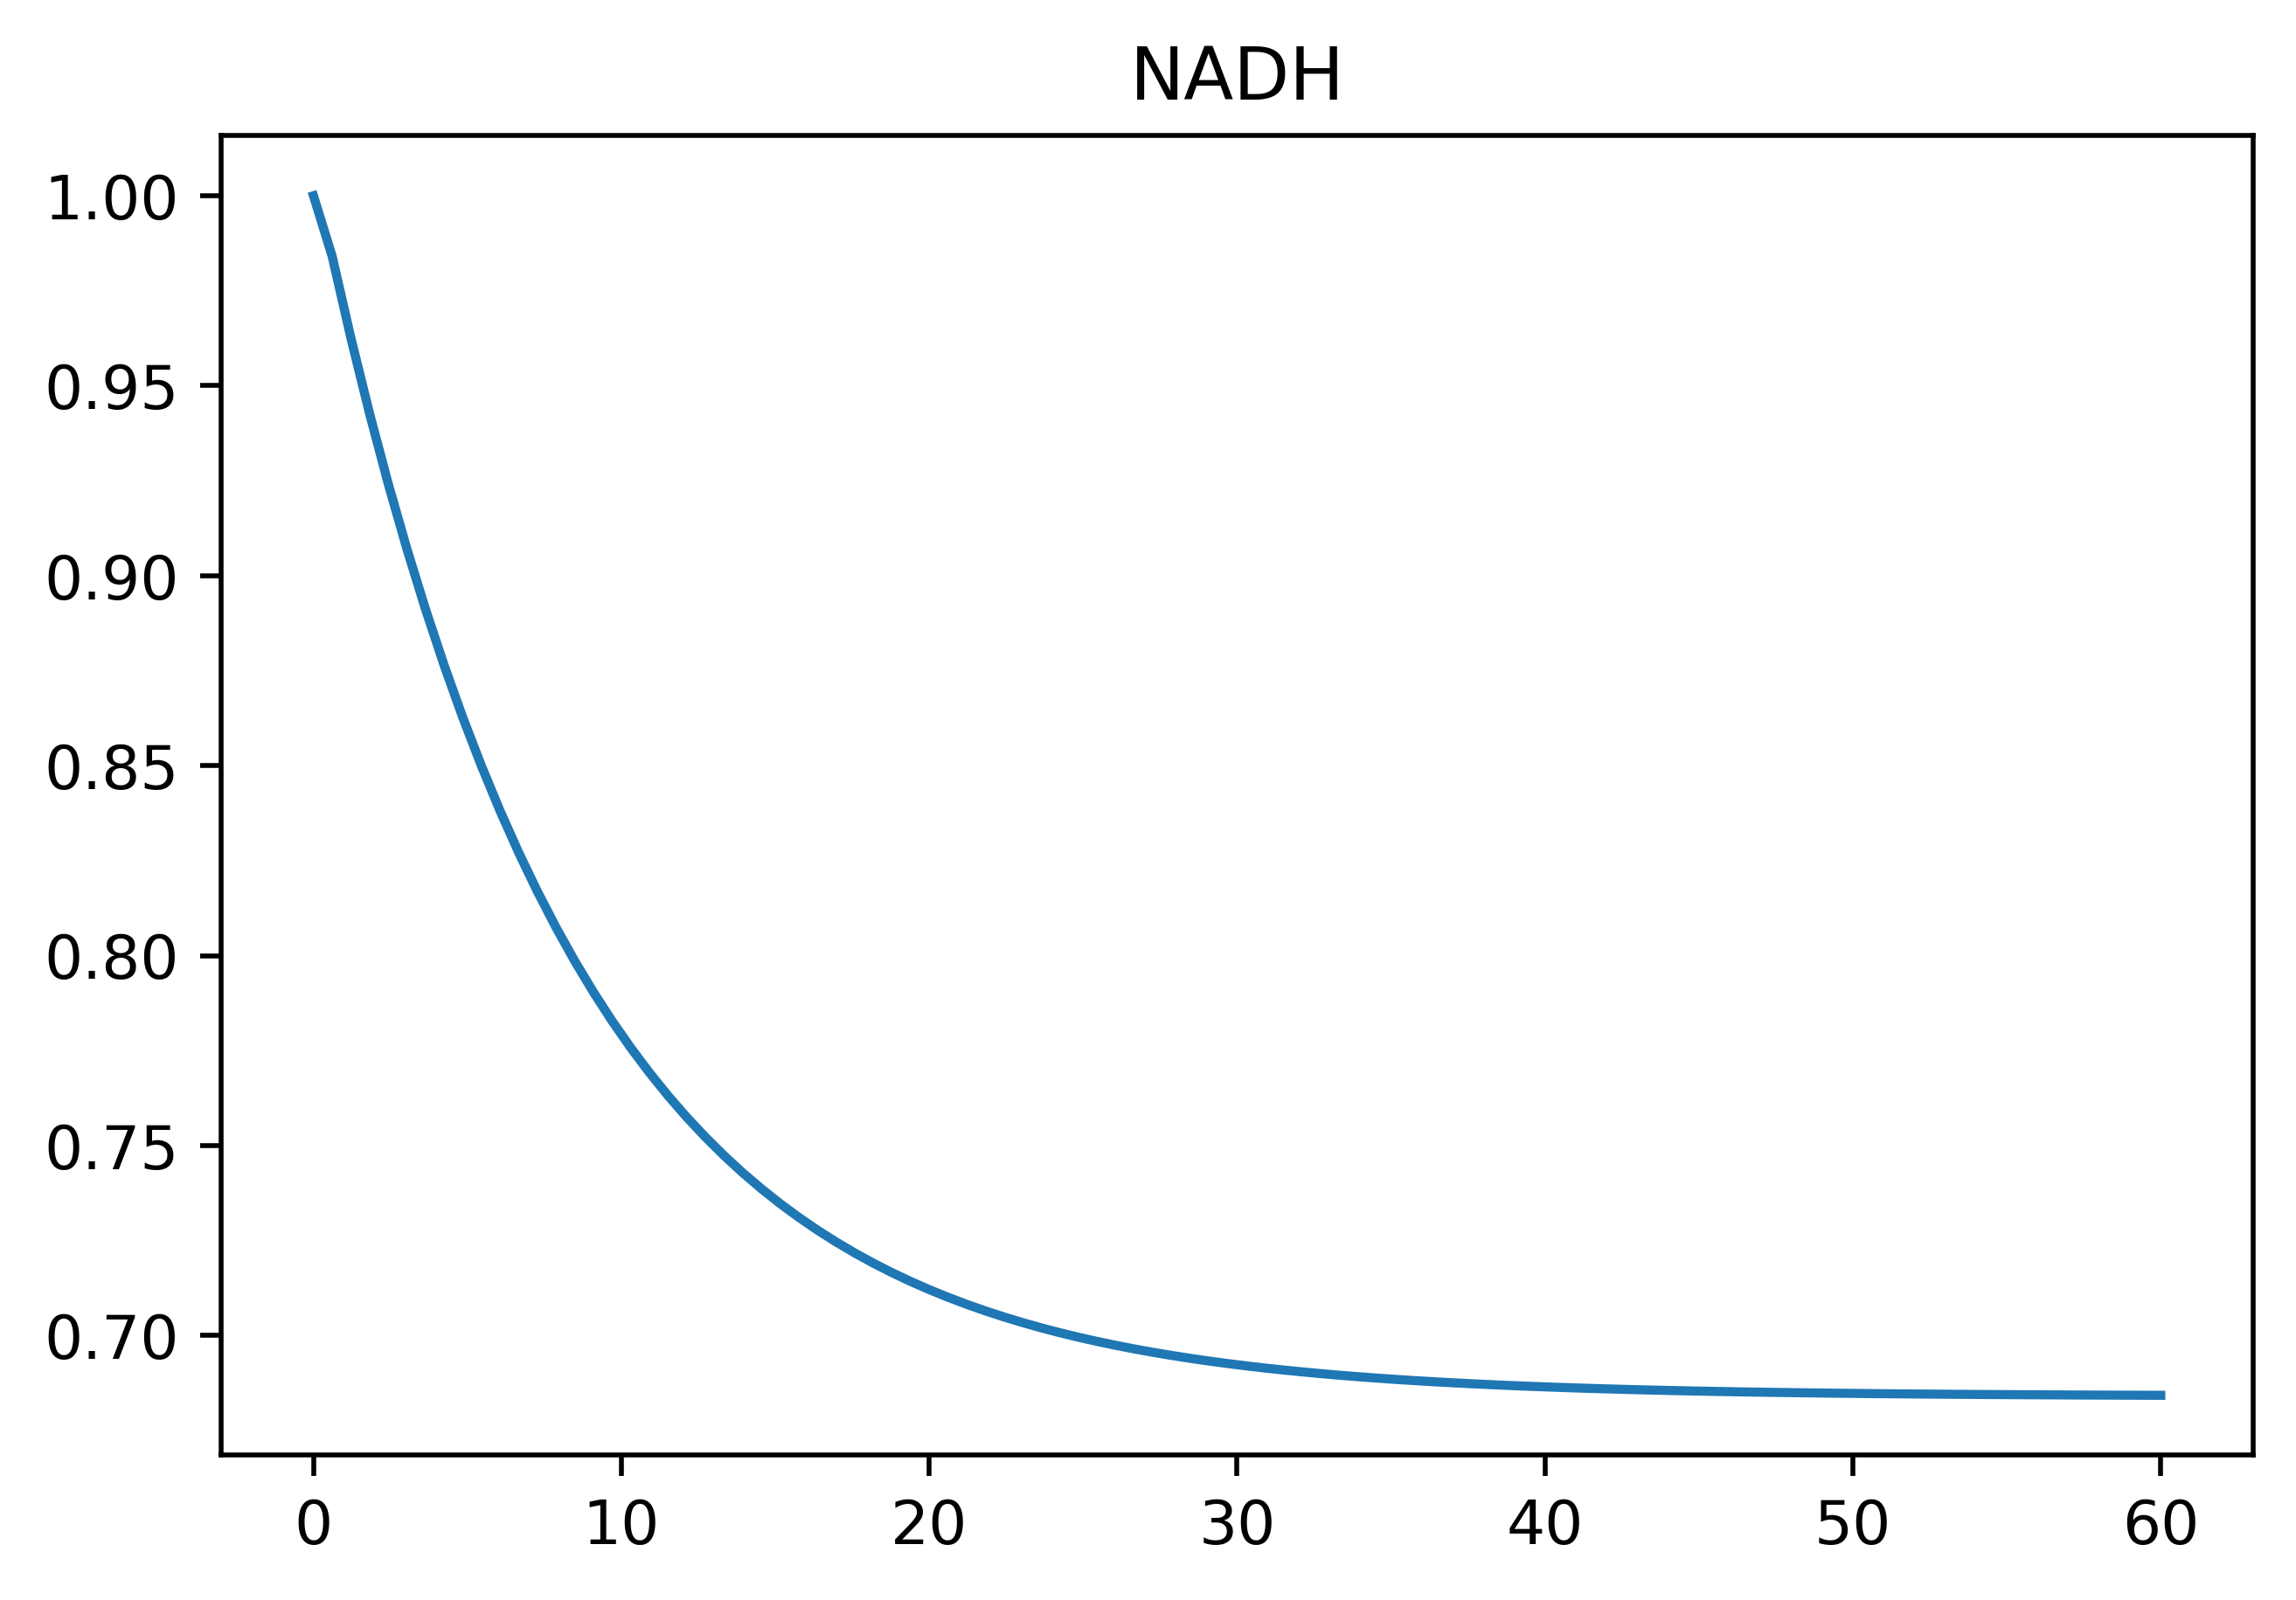

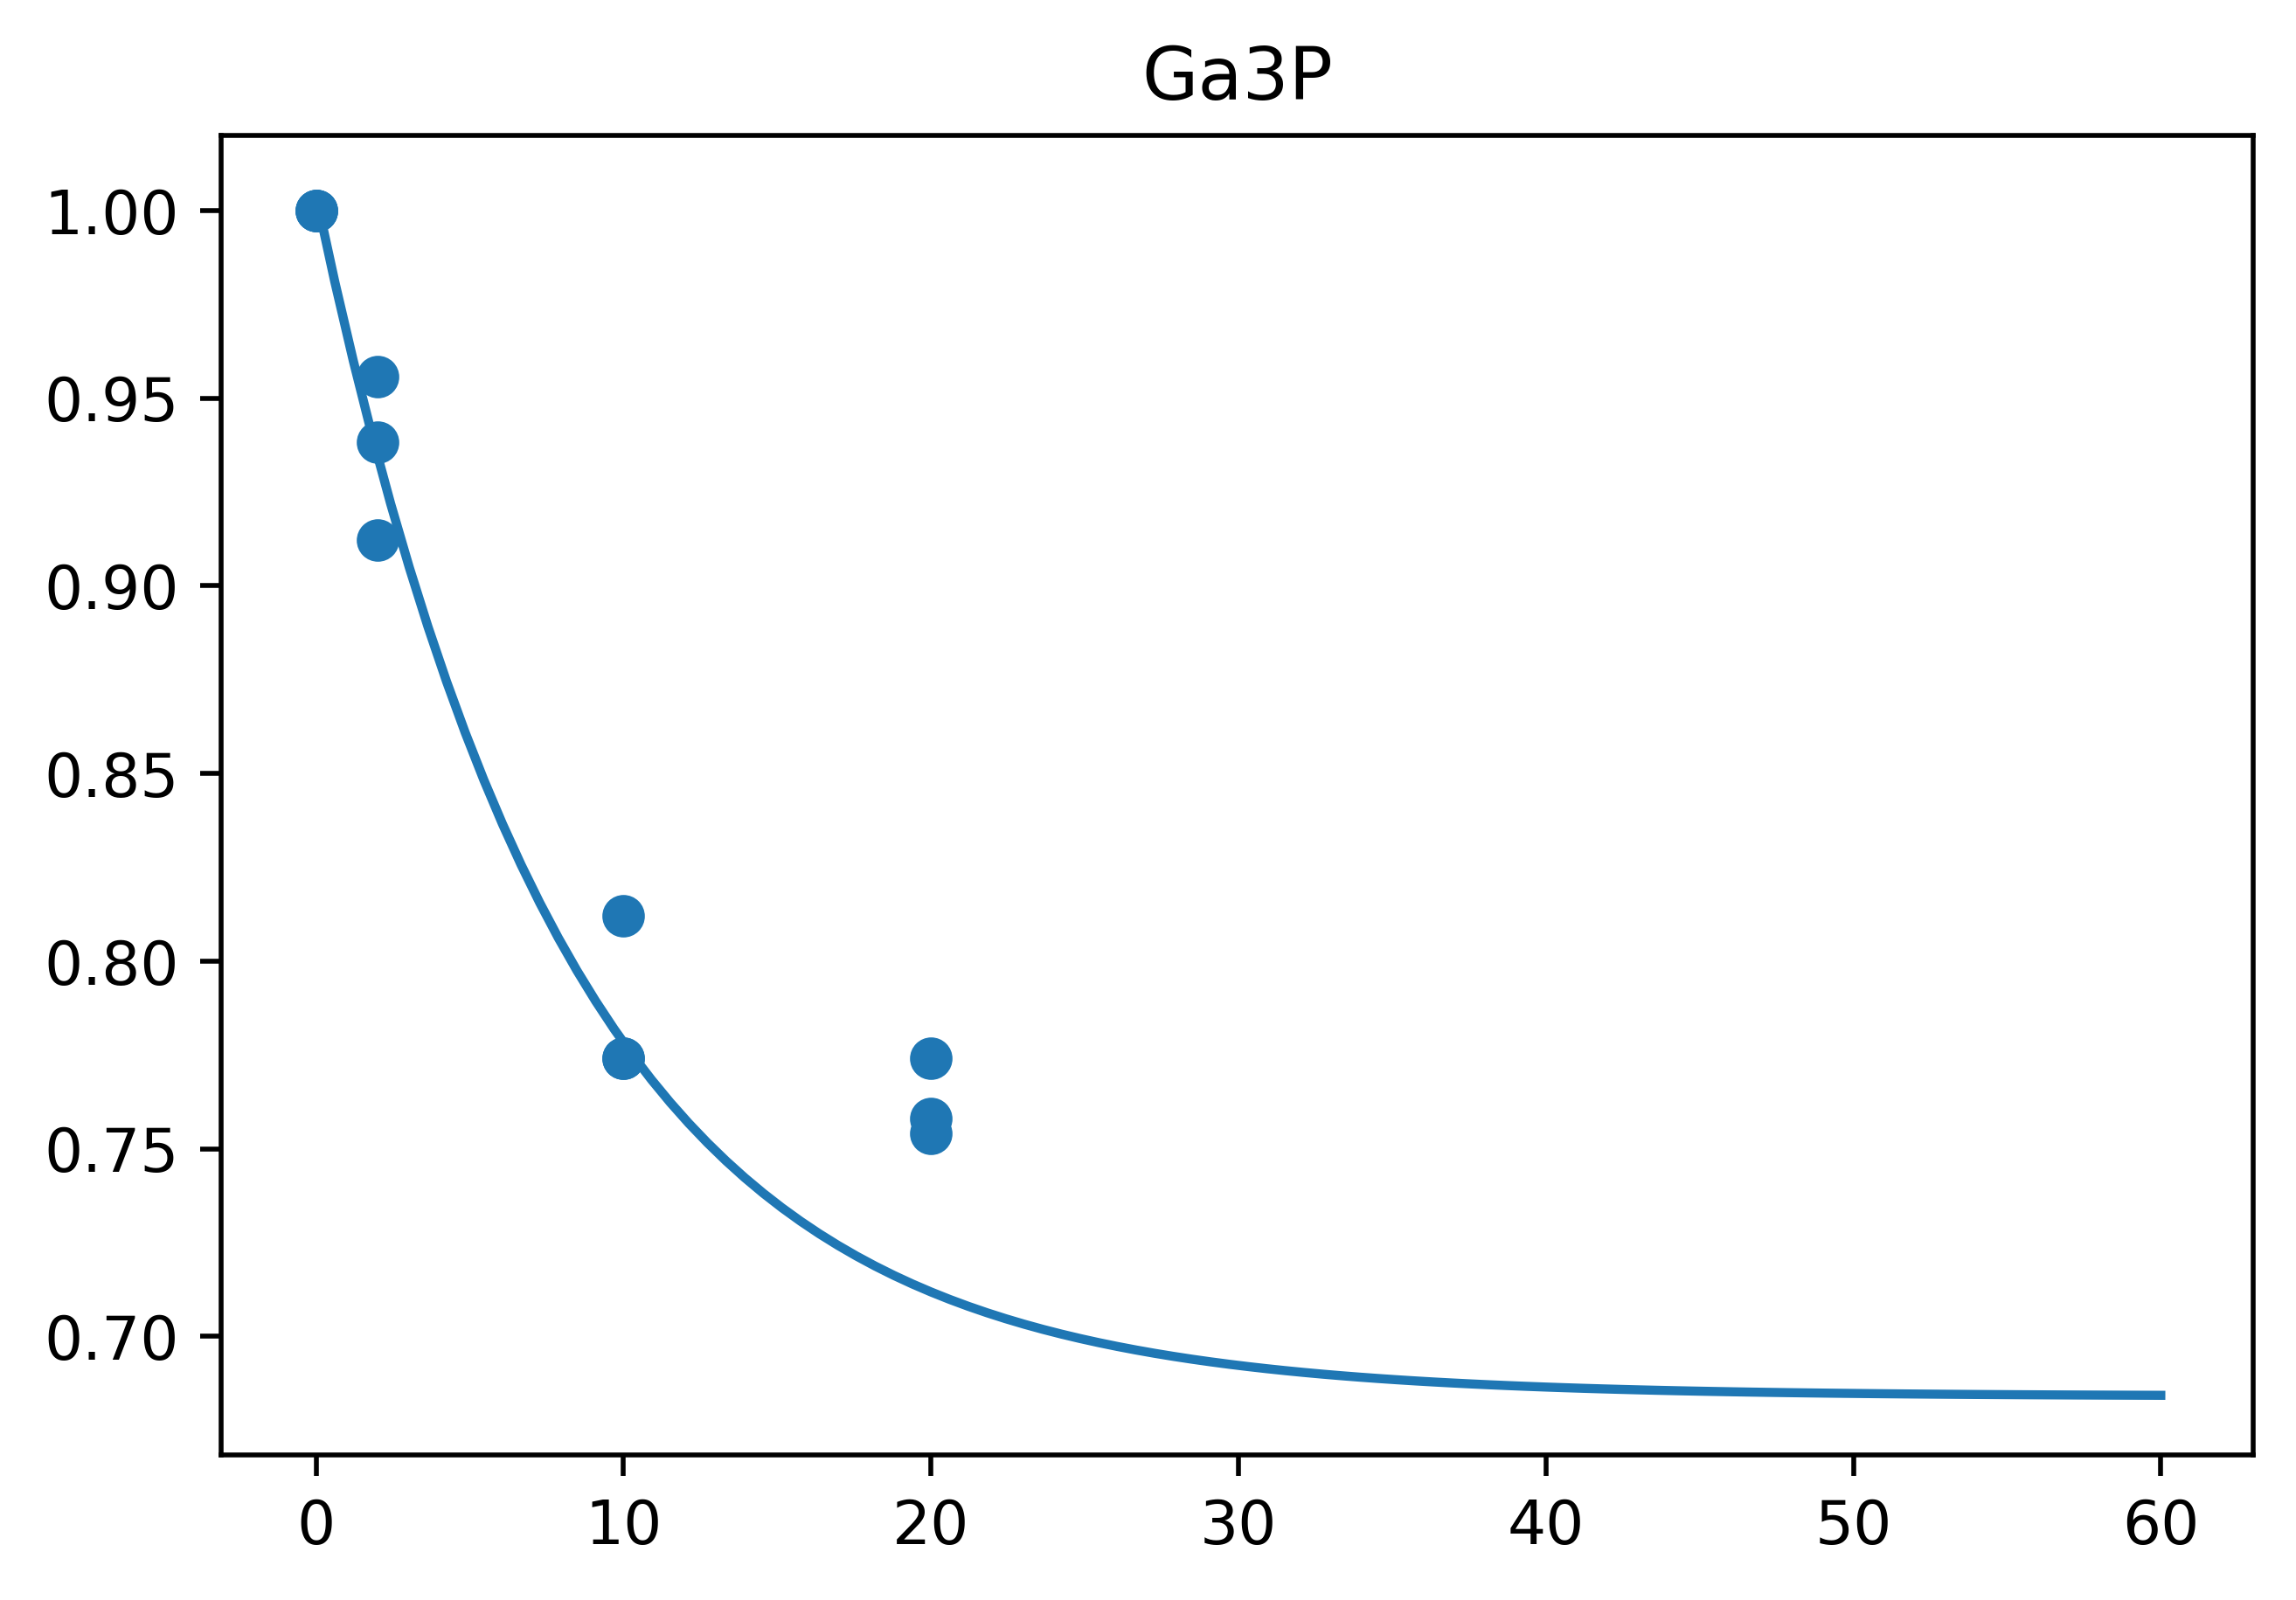

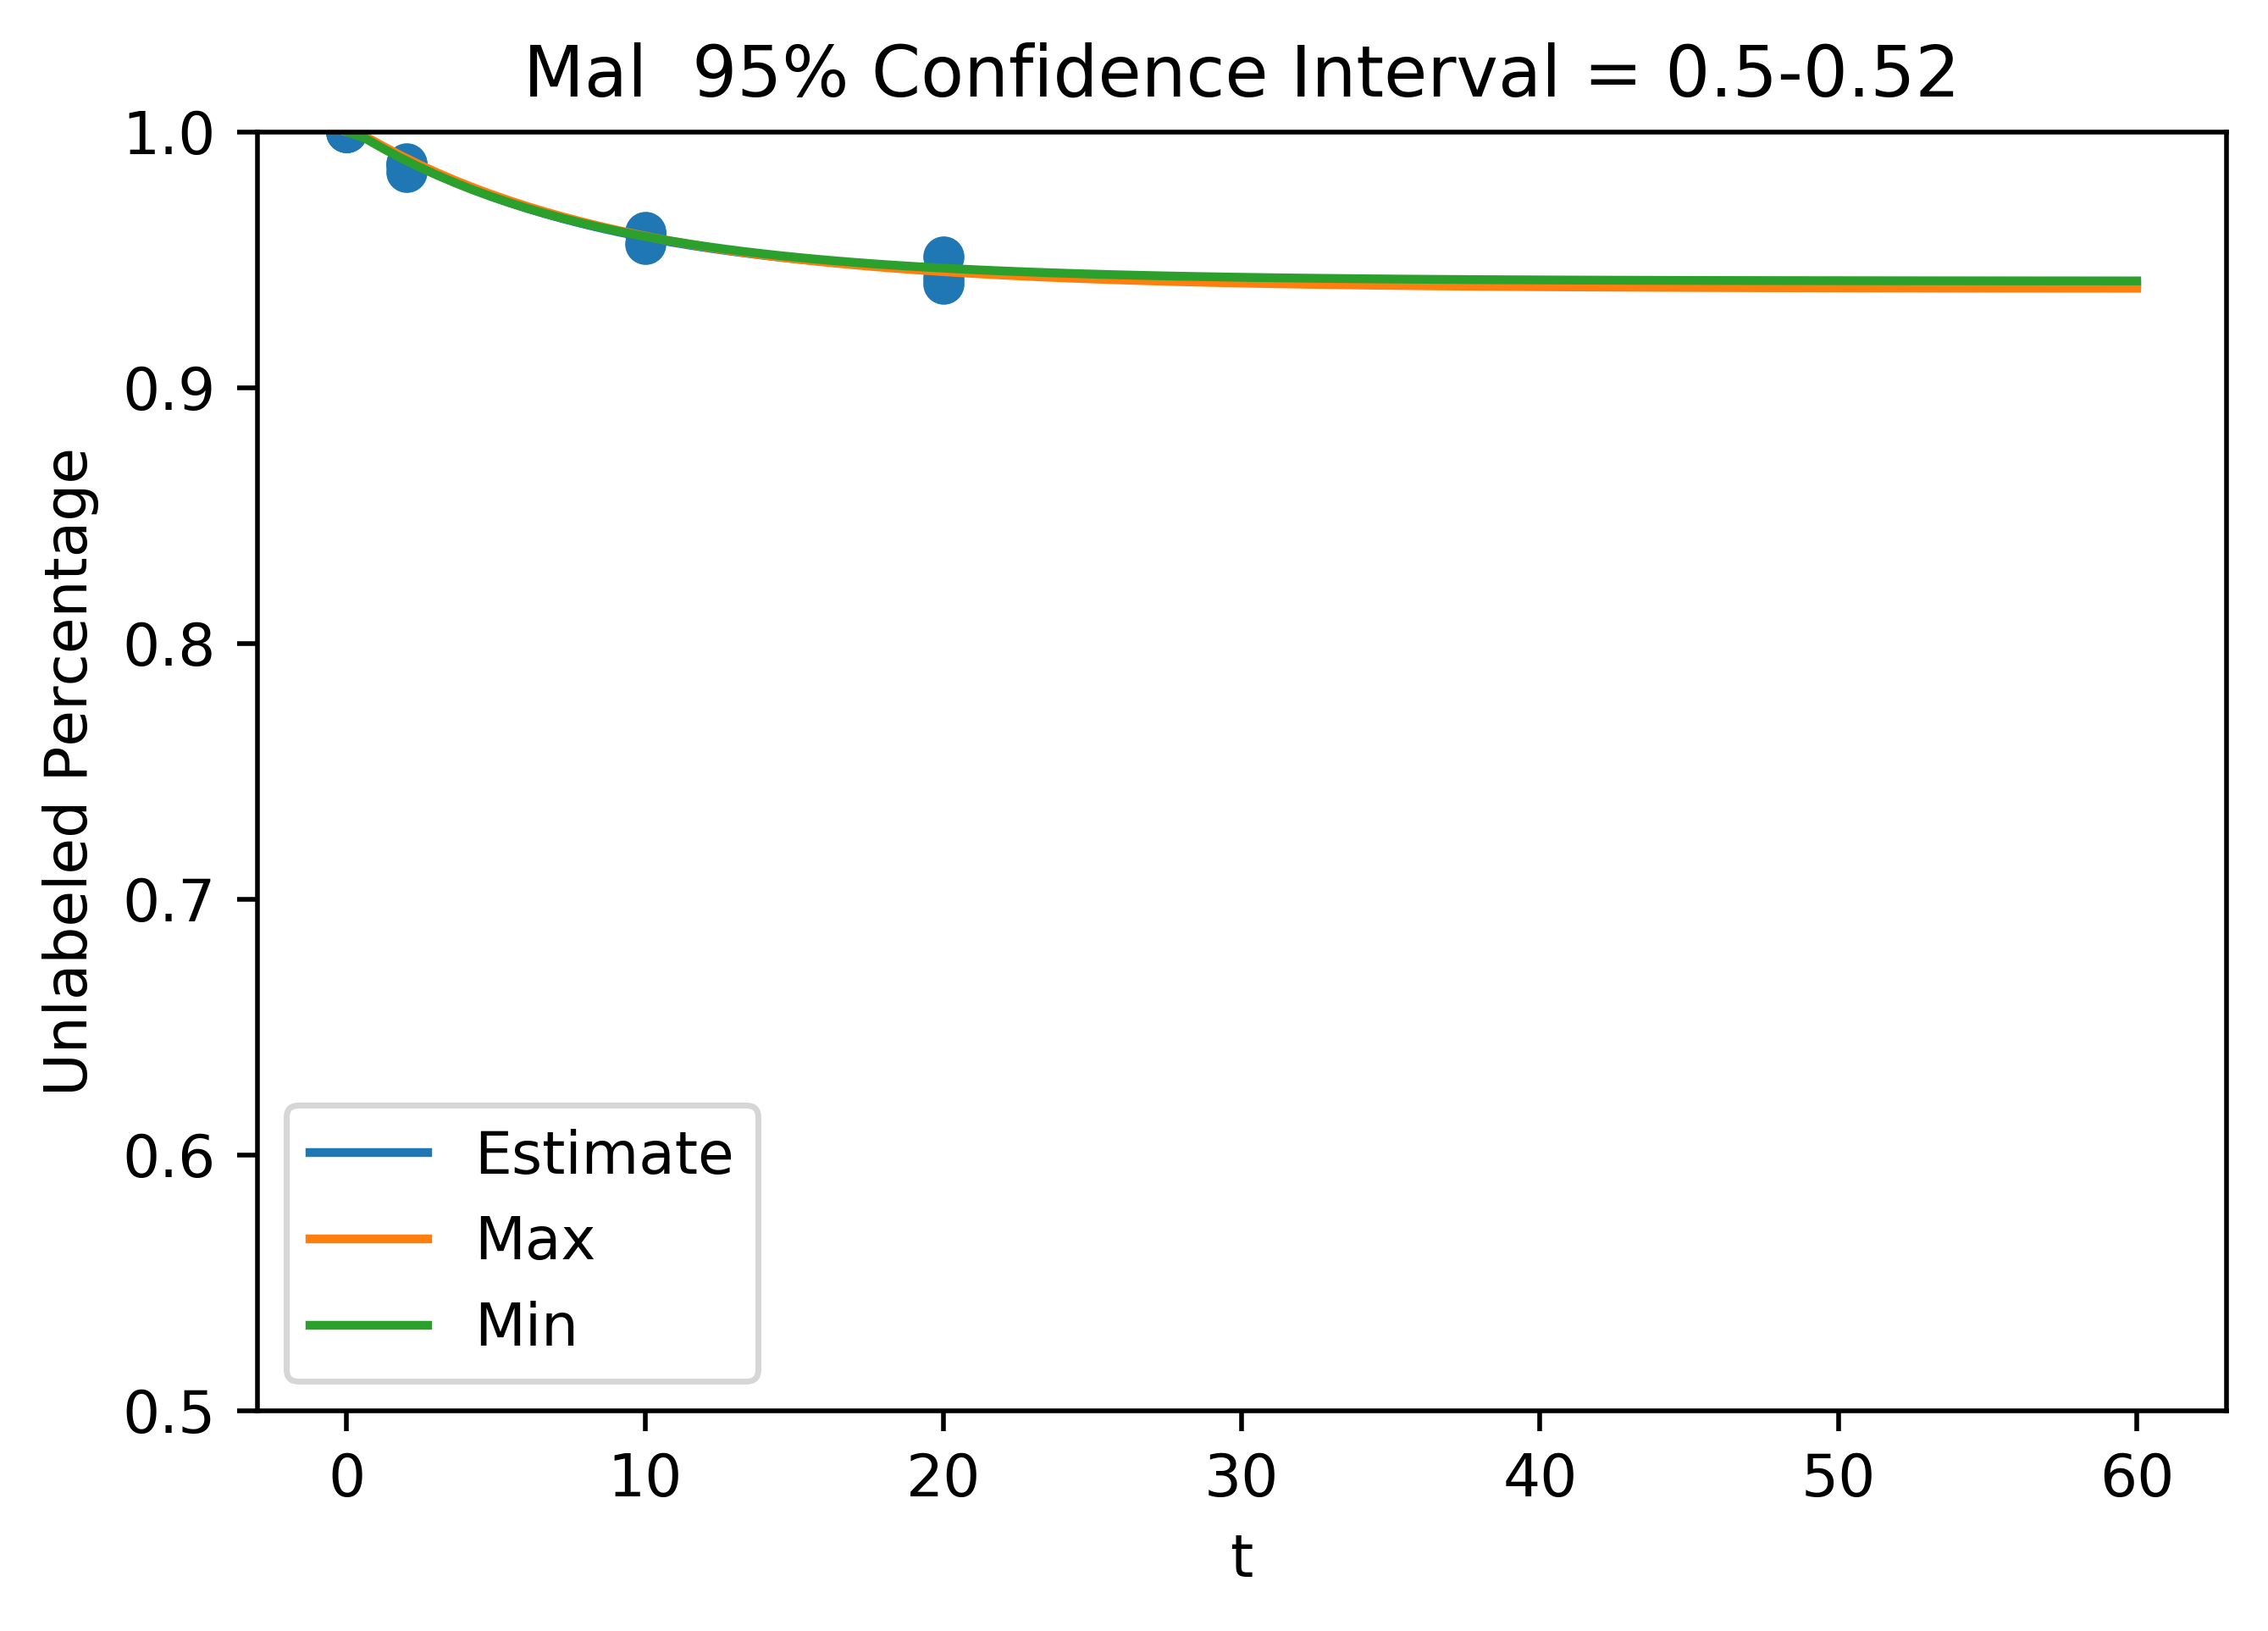

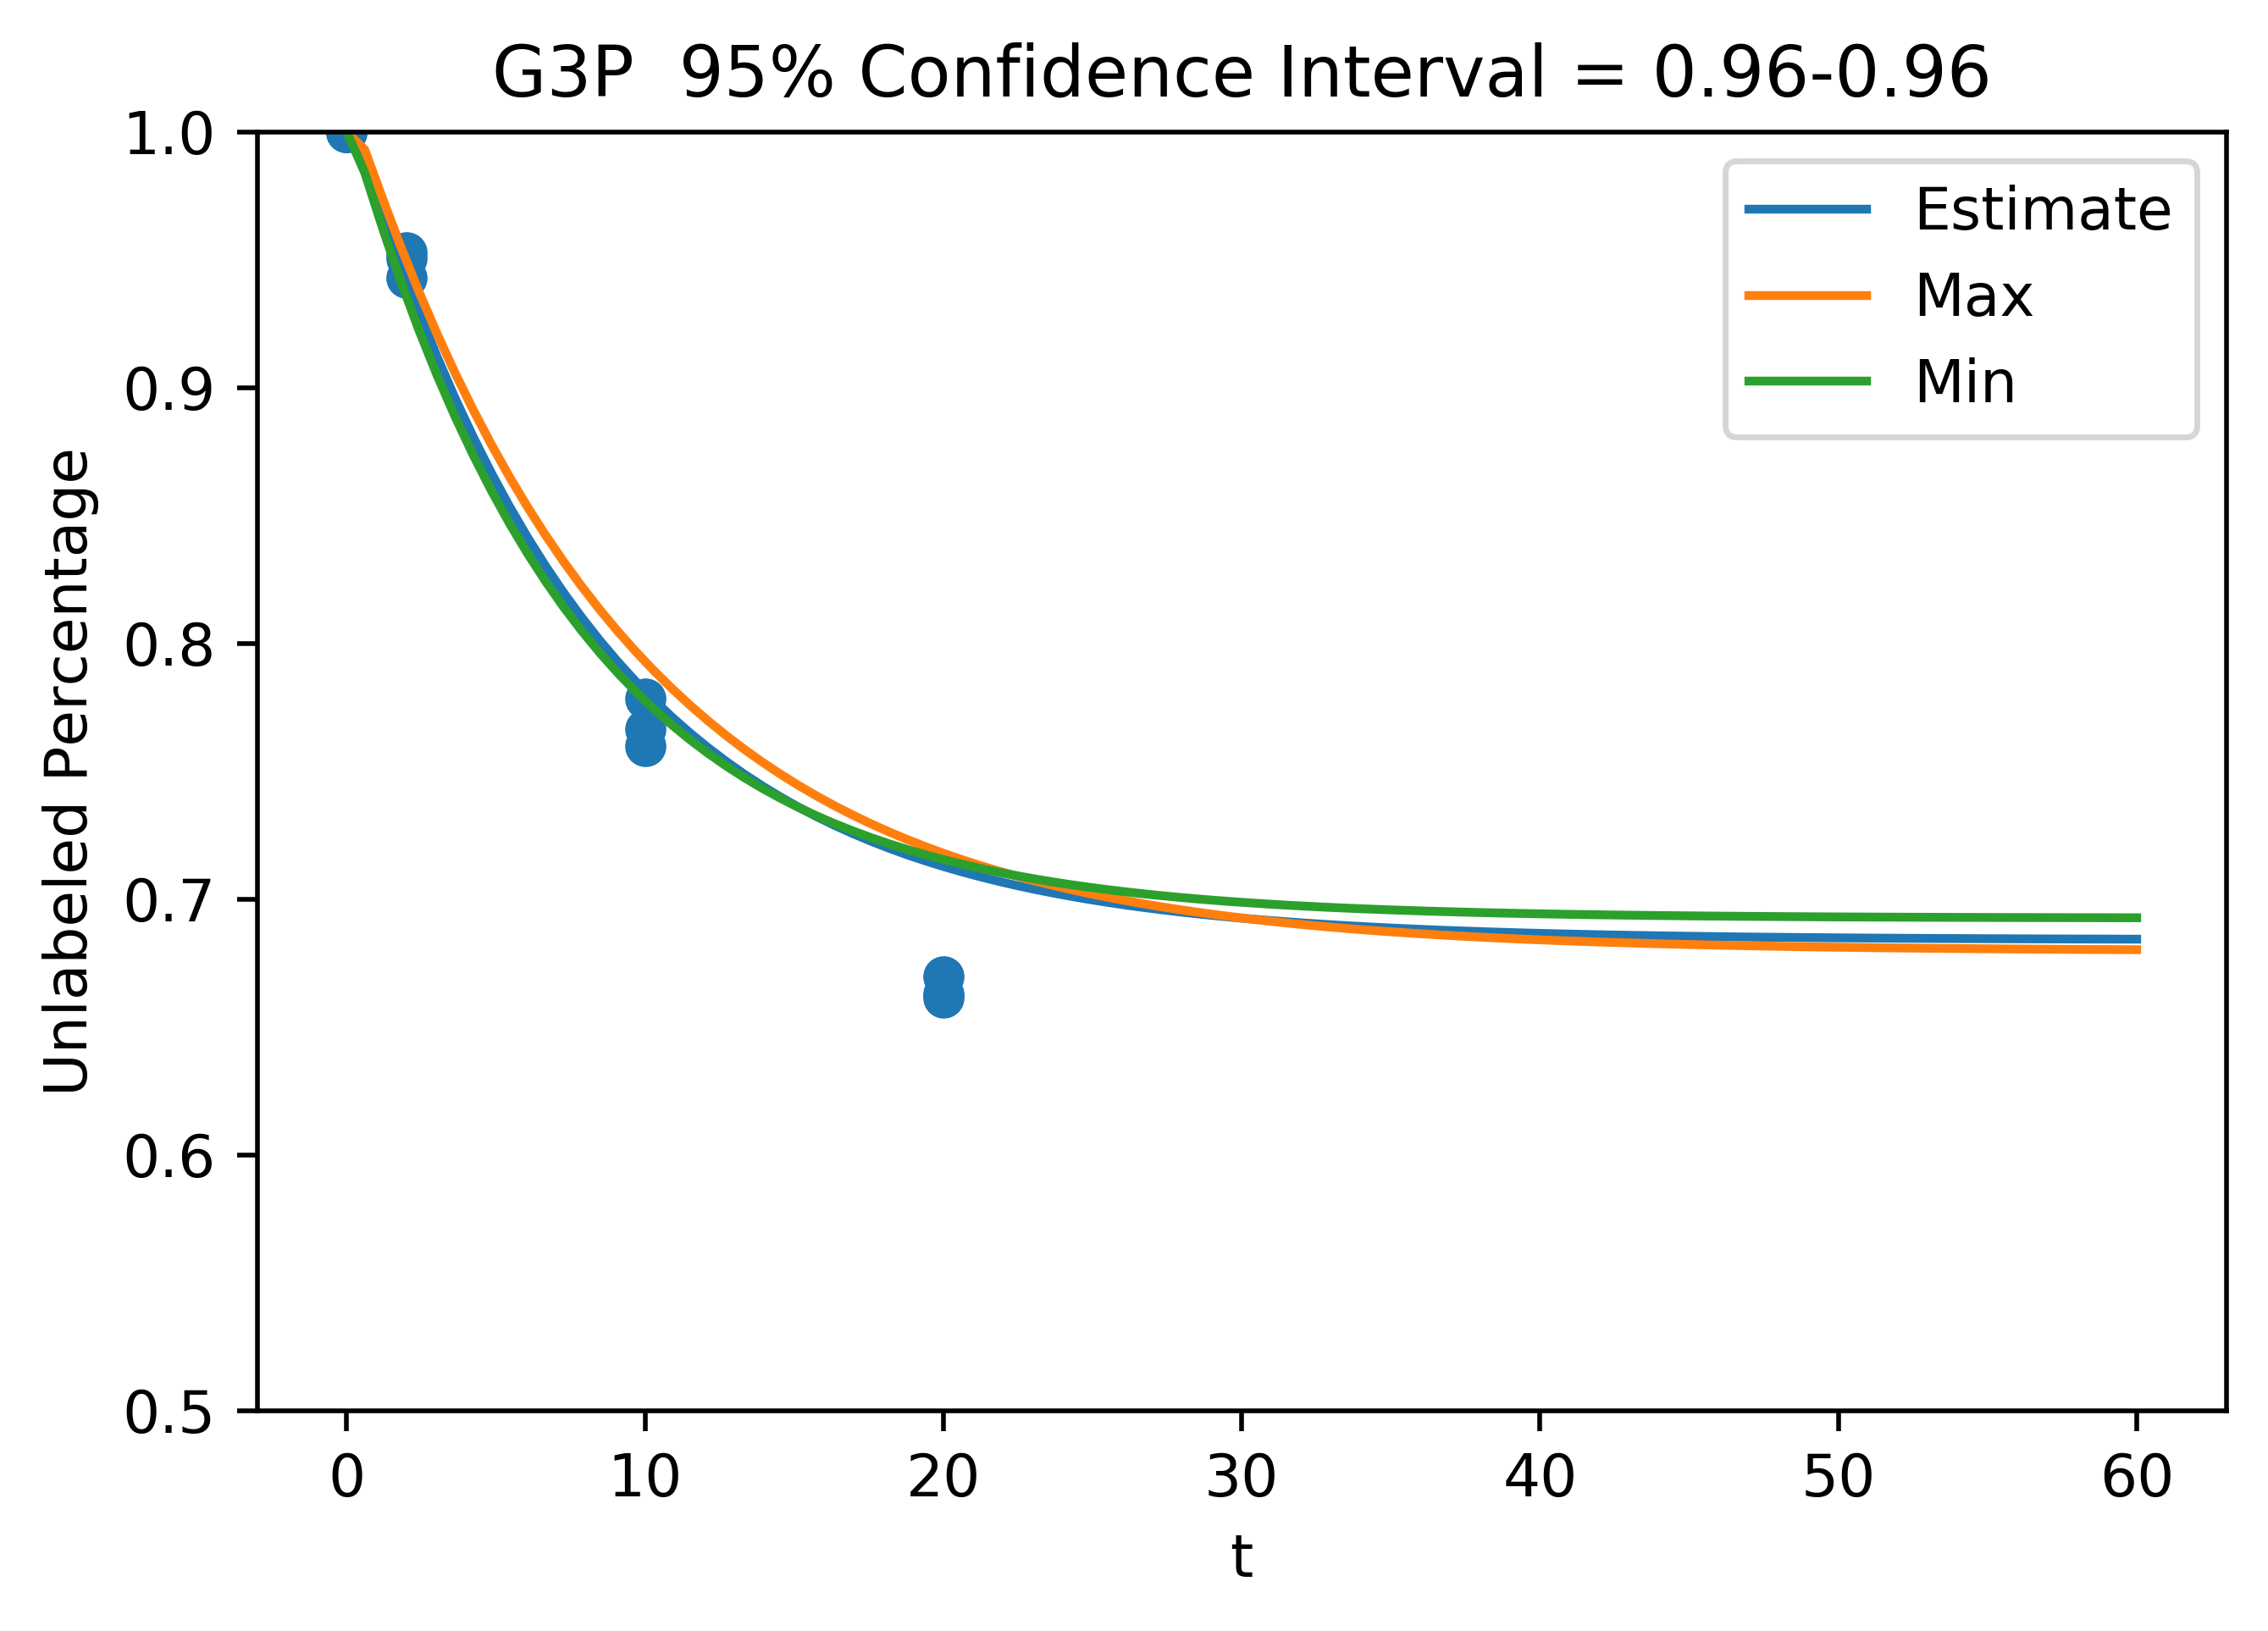

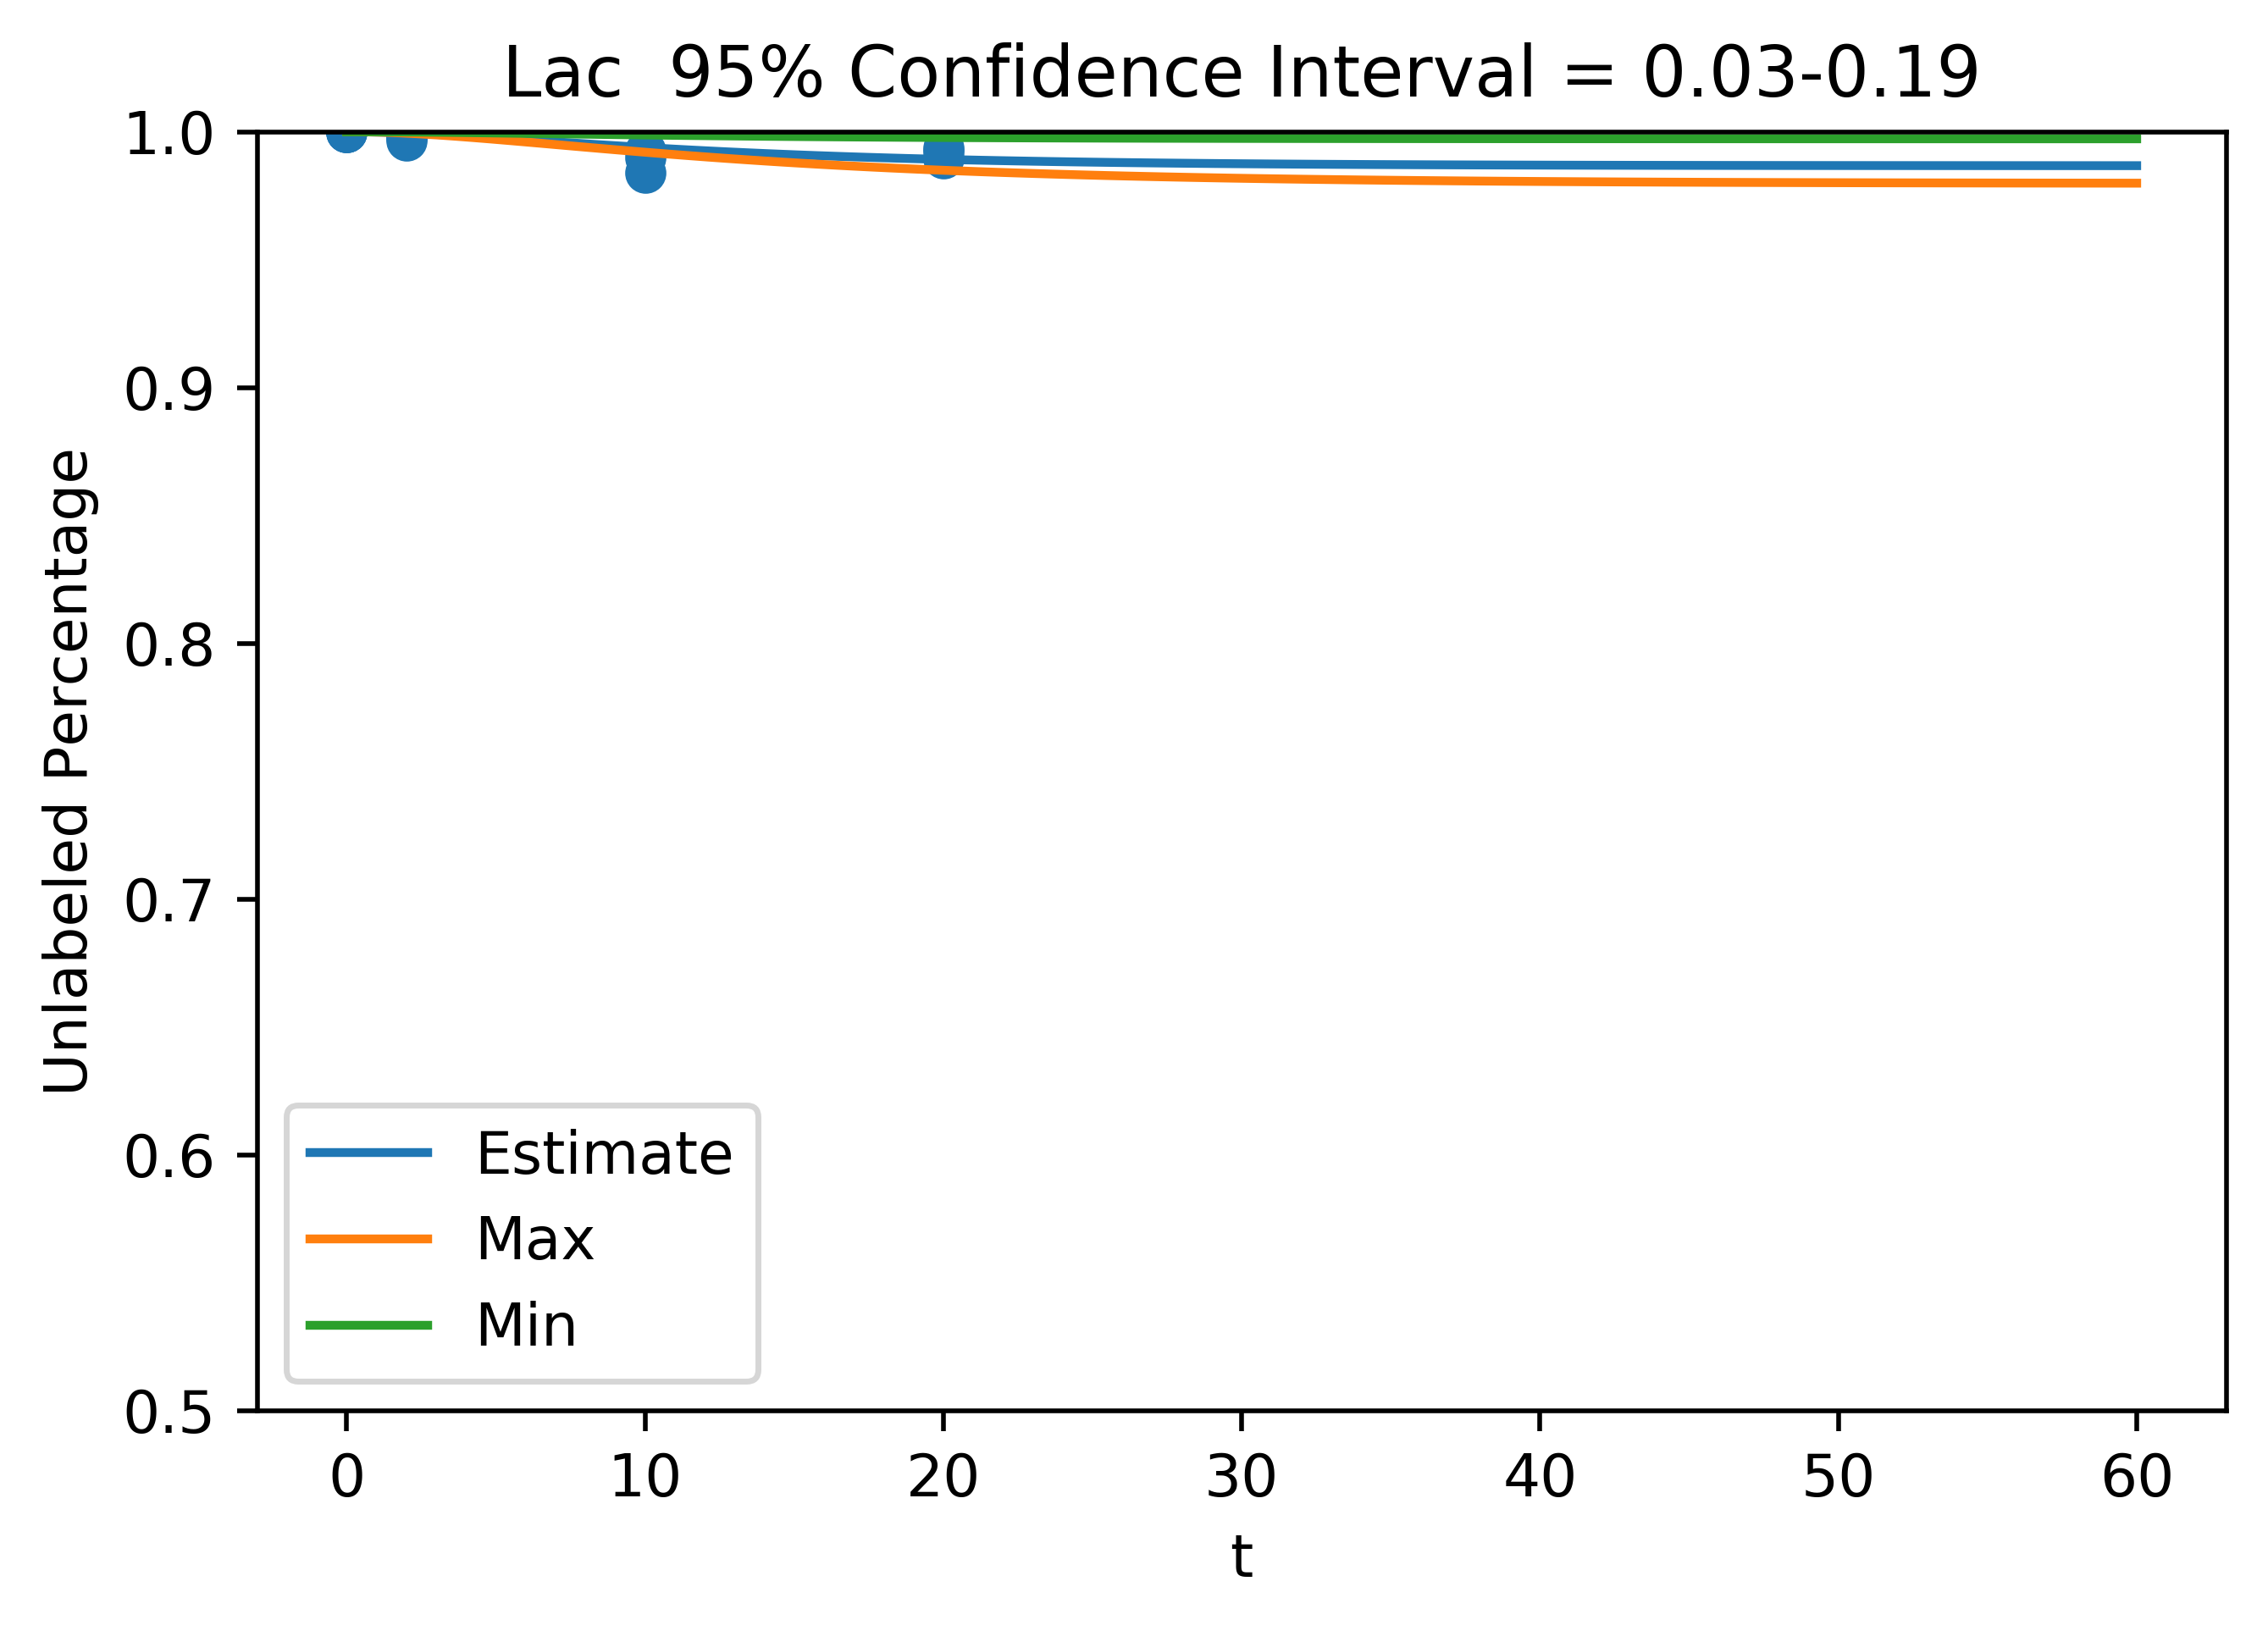

In [12]:
names = ["ga3p","Mal","G3P","Lac"]
plt.plot(t_t,predictedL[:,-1])
plt.title("NADH")

plt.figure()
plt.plot(t_t,predictedL[:,0])
plt.title("Ga3P")
plt.scatter(t,p[:,0])

for x in range(len(p[0])-1):
  print(intervalParams[x])
  fig = plt.figure()
  predictedMaxL = integrateLabelingModel(t_t,intervalParams[x][1][:3],np.append(conc[:-1],intervalParams[x][1][5:6]),intervalParams[x][1][6:-1],intervalParams[x][1][3:5])
  predictedMinL = integrateLabelingModel(t_t,intervalParams[x][0][:3],np.append(conc[:-1],intervalParams[x][0][5:6]),intervalParams[x][0][6:-1],intervalParams[x][0][3:5])
  plt.scatter(t,p[:,x+1])
  plt.plot(t_t,predictedL[:,x+1],label="Estimate")
  plt.plot(t_t,predictedMaxL[:,x+1],label="Max")
  plt.plot(t_t,predictedMinL[:,x+1],label="Min")
  plt.legend()

  plt.xlabel("t")
  plt.ylabel("Unlabeled Percentage")
  plt.title(names[x+1] + "  95% Confidence Interval = " + str(np.round(interval[x][0],2))+ "-" + str(np.round(interval[x][1],2)))

  plt.ylim((.5,1.0))
    
plt.show()



[array([ 4.99961083e-01,  9.59781361e-01,  8.88645554e-02,  2.17900408e+00,
        3.15113544e+00,  1.32038906e-01,  3.13654501e-01, -1.24132997e-01,
        6.87322556e-01,  5.05931595e-04]), array([ 5.15092278e-01,  9.59750052e-01,  1.14605510e-01,  2.17549353e+00,
        3.12539449e+00,  1.32049147e-01,  3.24794720e-01, -1.13768805e-01,
        6.80042734e-01,  3.61522468e-04])]
[array([ 5.06703790e-01,  9.57401130e-01,  7.86893912e-02,  2.17729814e+00,
        3.16131061e+00,  1.38544209e-01,  3.05005065e-01, -1.31275000e-01,
        6.92552752e-01,  4.05908781e-04]), array([ 5.09053490e-01,  9.60841527e-01,  1.27970376e-01,  2.17696289e+00,
        3.11202962e+00,  1.29105913e-01,  3.26112675e-01, -1.08601885e-01,
        6.79683607e-01,  4.62848564e-04])]
[array([ 5.06306787e-01,  9.59953739e-01,  2.79275973e-02,  2.17754957e+00,
        3.21207240e+00,  1.31549232e-01,  3.34090933e-01, -1.25320512e-01,
        6.80624801e-01,  3.83684916e-04]), array([ 5.05988506e-01,  9.60627

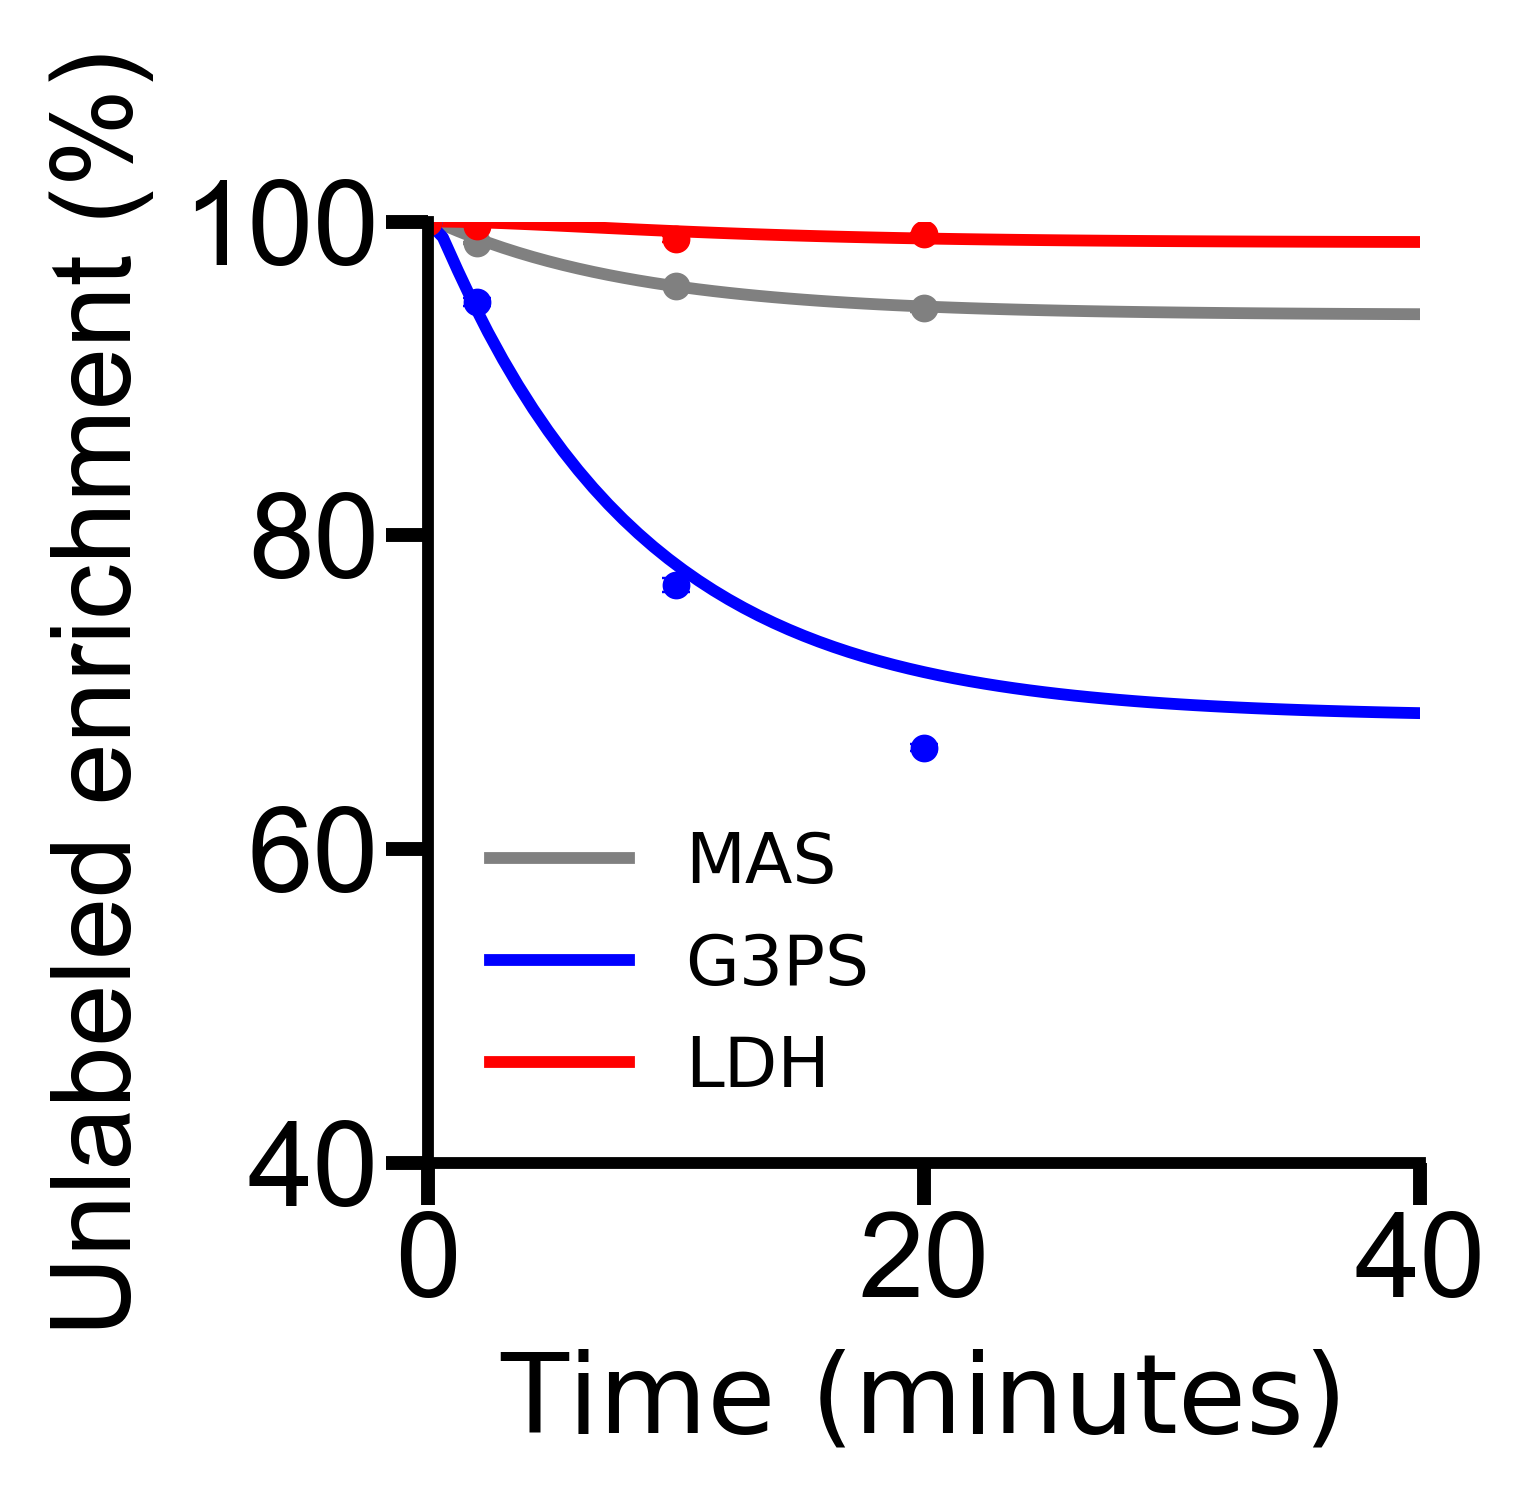

In [13]:
names = ["Glyceraldehyde 3 Phosphate","MAS","G3PS","LDH"]
plt.rcParams["font.weight"] = 500
plt.rcParams["axes.labelweight"] = 500
uniqueTs = list(set(t))
uniqueTs.sort()
#pp = PdfPages(cellType + '.pdf')
limits = [(40,100),(40,100),(40,100)]
colors = ["Grey","Blue","Red"]
fig,ax = plt.subplots(figsize=(3,3))

for x,color in zip(range(len(p[0])-1),colors):
  data2Plot = {tt:[] for tt in uniqueTs}
  for tt,ll in zip(t,p[:,x+1]):
        data2Plot[tt].append(ll)
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt])/np.sqrt(len(data2Plot[tt])) for tt in uniqueTs] 
  
  print(intervalParams[x])
  integrateLabelingModel(t_t,intervalParams[x][0][:3],conc,intervalParams[x][0][6:],intervalParams[x][0][3:6])
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color=color,capthick=.35,markersize=3,elinewidth=0.5)
  plt.plot(t_t,[100*i for i in predictedL[:,x+1]],label=names[x+1],color=color,linewidth=1.7)
 
  #plt.xlabel("Time (minutes)",fontname="Arial",fontsize=16,color='black')
  plt.xlabel("Time (minutes)",fontsize=16,color='black')
  plt.ylabel("Unlabeled enrichment (%)",fontsize = 16,fontname = "Arial",color='black')
  #plt.title(names[x+1] + " Flux = " + str(np.round(bestParams[x],2)) + " 95% CI = [" + str(np.round(interval[x][0],2))+ "," + str(np.round(interval[x][1],2)) + "]")
  #plt.title(names[x+1],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
ax=plt.gca();
ax.spines['bottom'].set_linewidth(1.7);
ax.spines['left'].set_linewidth(1.7);
plt.tick_params(labelsize=17)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

axis = plt.gca().xaxis
axis.get_ticklabels()  
axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    
axis = plt.gca().yaxis
axis.get_ticklabels()  
axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    




right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.legend(frameon=False) 
plt.savefig("../data/" + cellType + "/" + cellType + ".png")
#pp.savefig(fig)
#pp.savefig(fig)






[array([ 4.99961083e-01,  9.59781361e-01,  8.88645554e-02,  2.17900408e+00,
        3.15113544e+00,  1.32038906e-01,  3.13654501e-01, -1.24132997e-01,
        6.87322556e-01,  5.05931595e-04]), array([ 5.15092278e-01,  9.59750052e-01,  1.14605510e-01,  2.17549353e+00,
        3.12539449e+00,  1.32049147e-01,  3.24794720e-01, -1.13768805e-01,
        6.80042734e-01,  3.61522468e-04])]
[array([ 5.06703790e-01,  9.57401130e-01,  7.86893912e-02,  2.17729814e+00,
        3.16131061e+00,  1.38544209e-01,  3.05005065e-01, -1.31275000e-01,
        6.92552752e-01,  4.05908781e-04]), array([ 5.09053490e-01,  9.60841527e-01,  1.27970376e-01,  2.17696289e+00,
        3.11202962e+00,  1.29105913e-01,  3.26112675e-01, -1.08601885e-01,
        6.79683607e-01,  4.62848564e-04])]
[array([ 5.06306787e-01,  9.59953739e-01,  2.79275973e-02,  2.17754957e+00,
        3.21207240e+00,  1.31549232e-01,  3.34090933e-01, -1.25320512e-01,
        6.80624801e-01,  3.83684916e-04]), array([ 5.05988506e-01,  9.60627

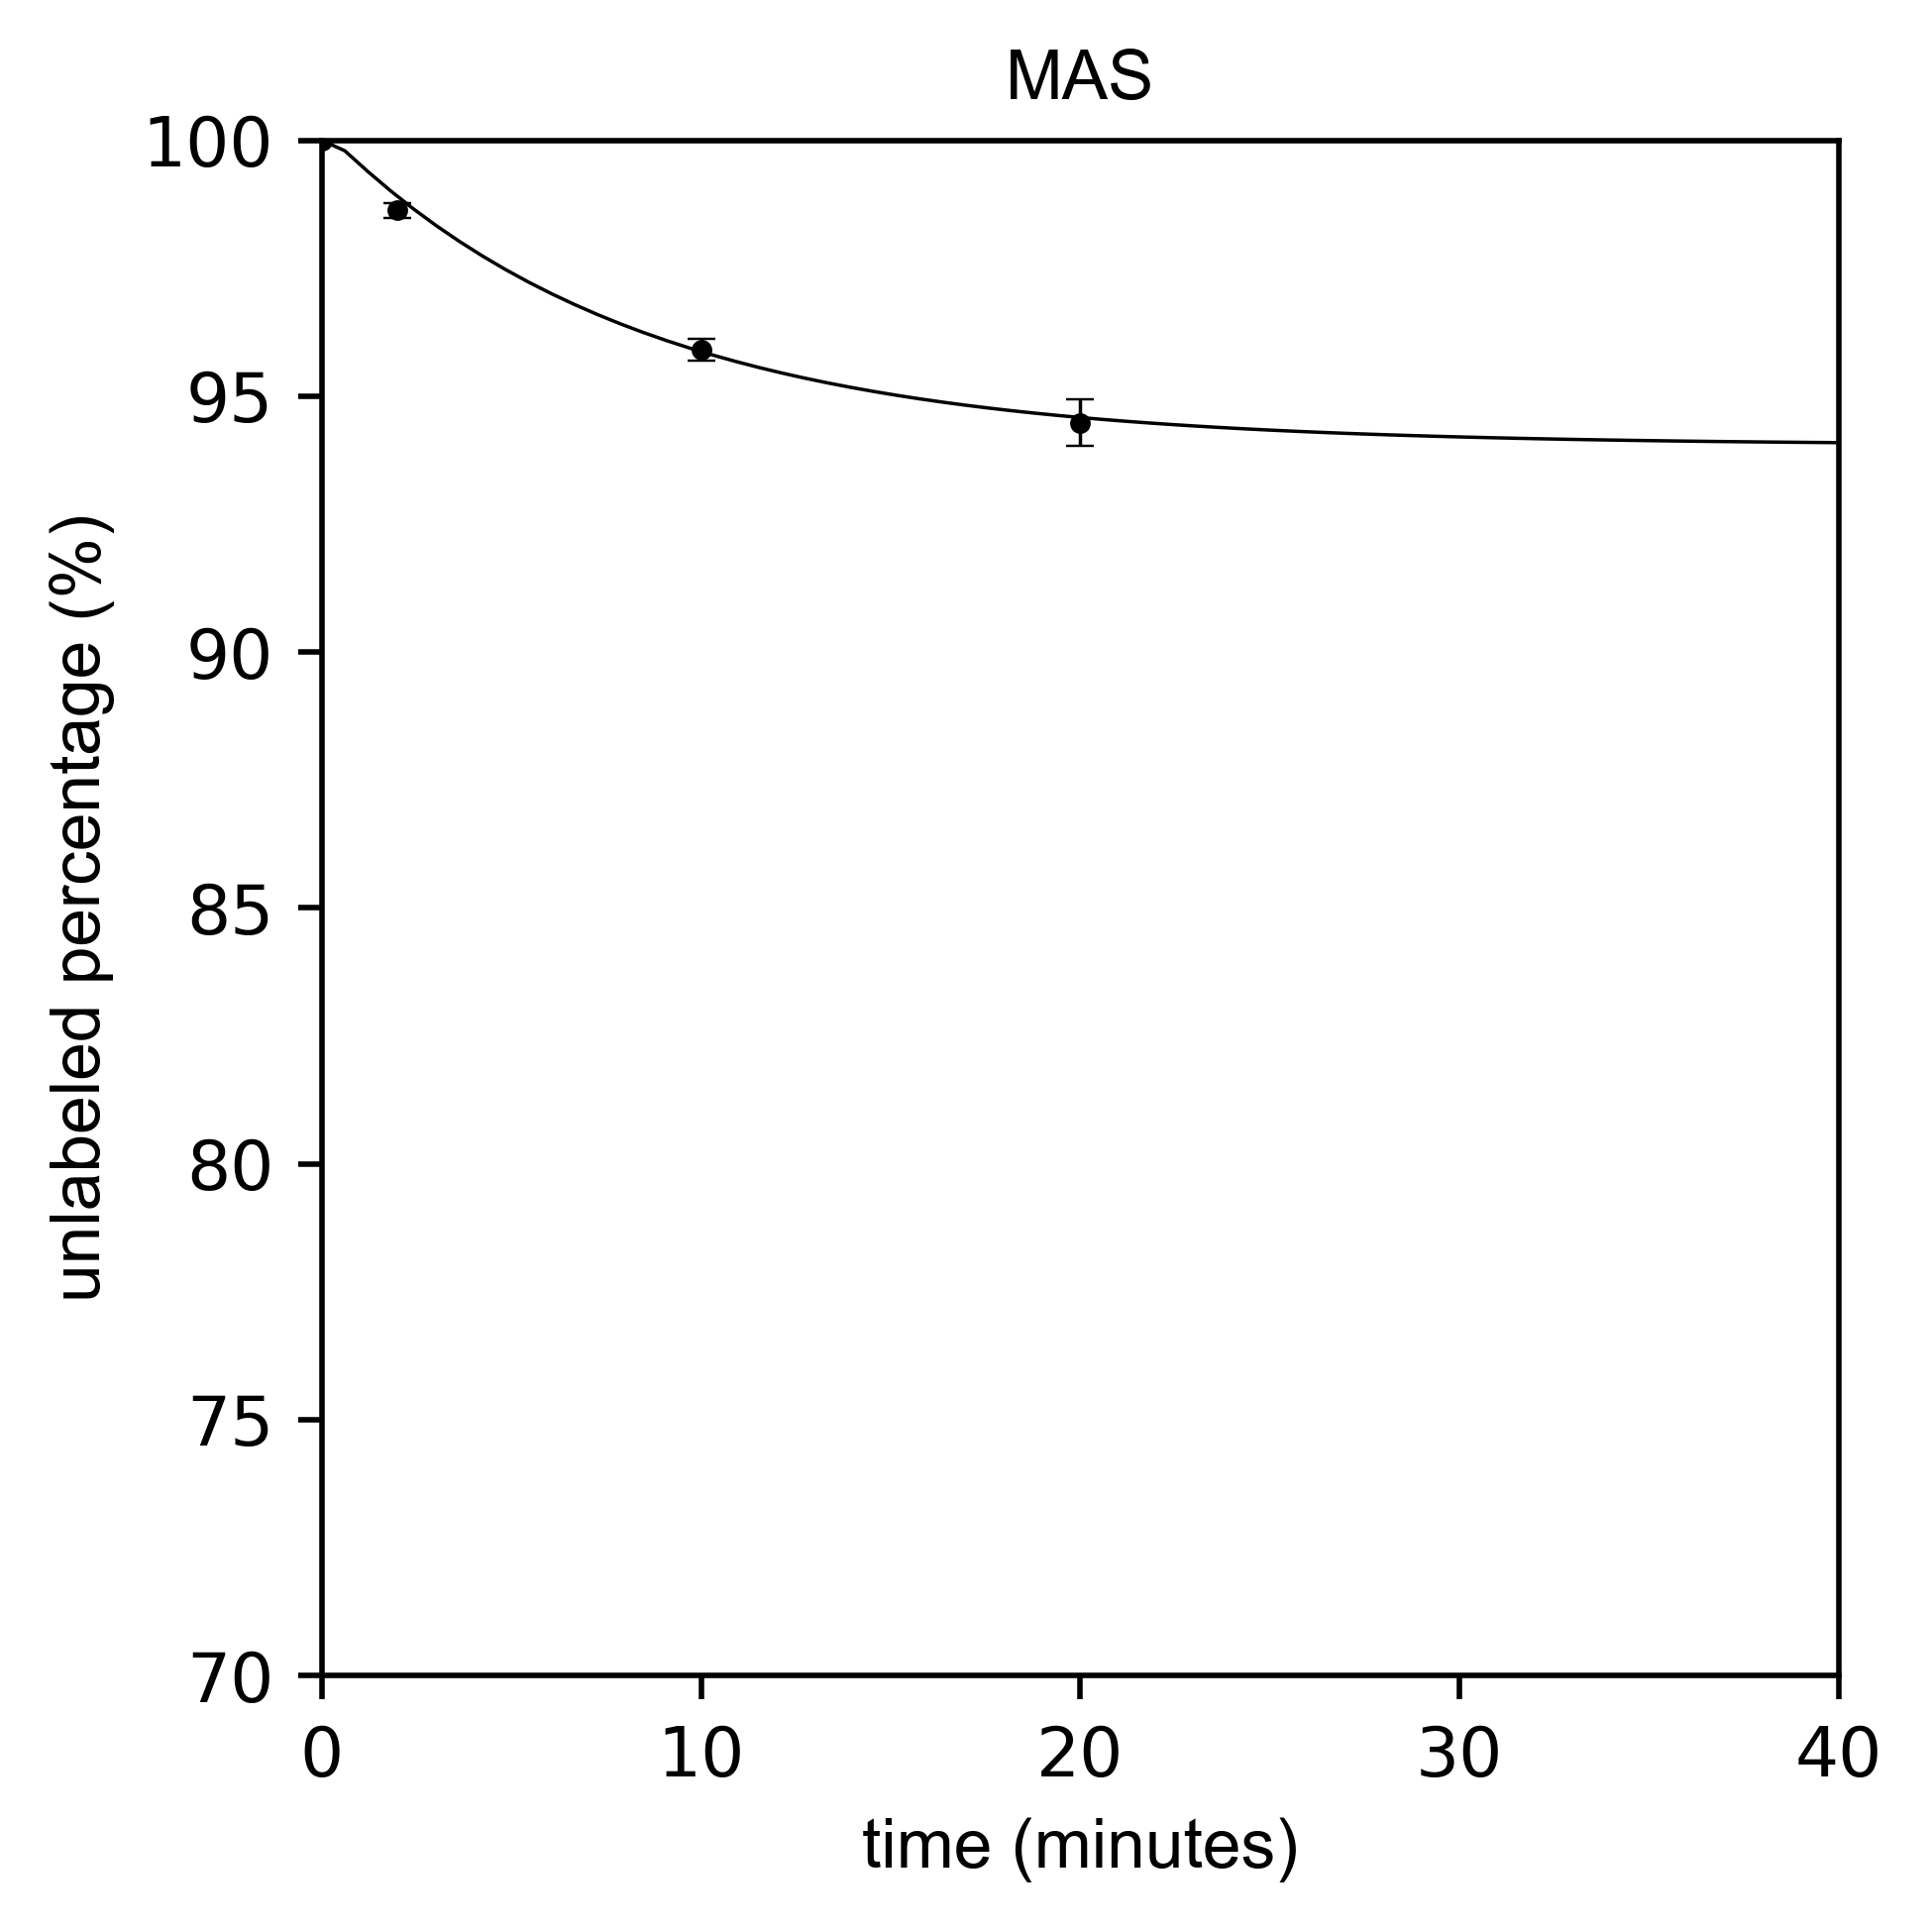

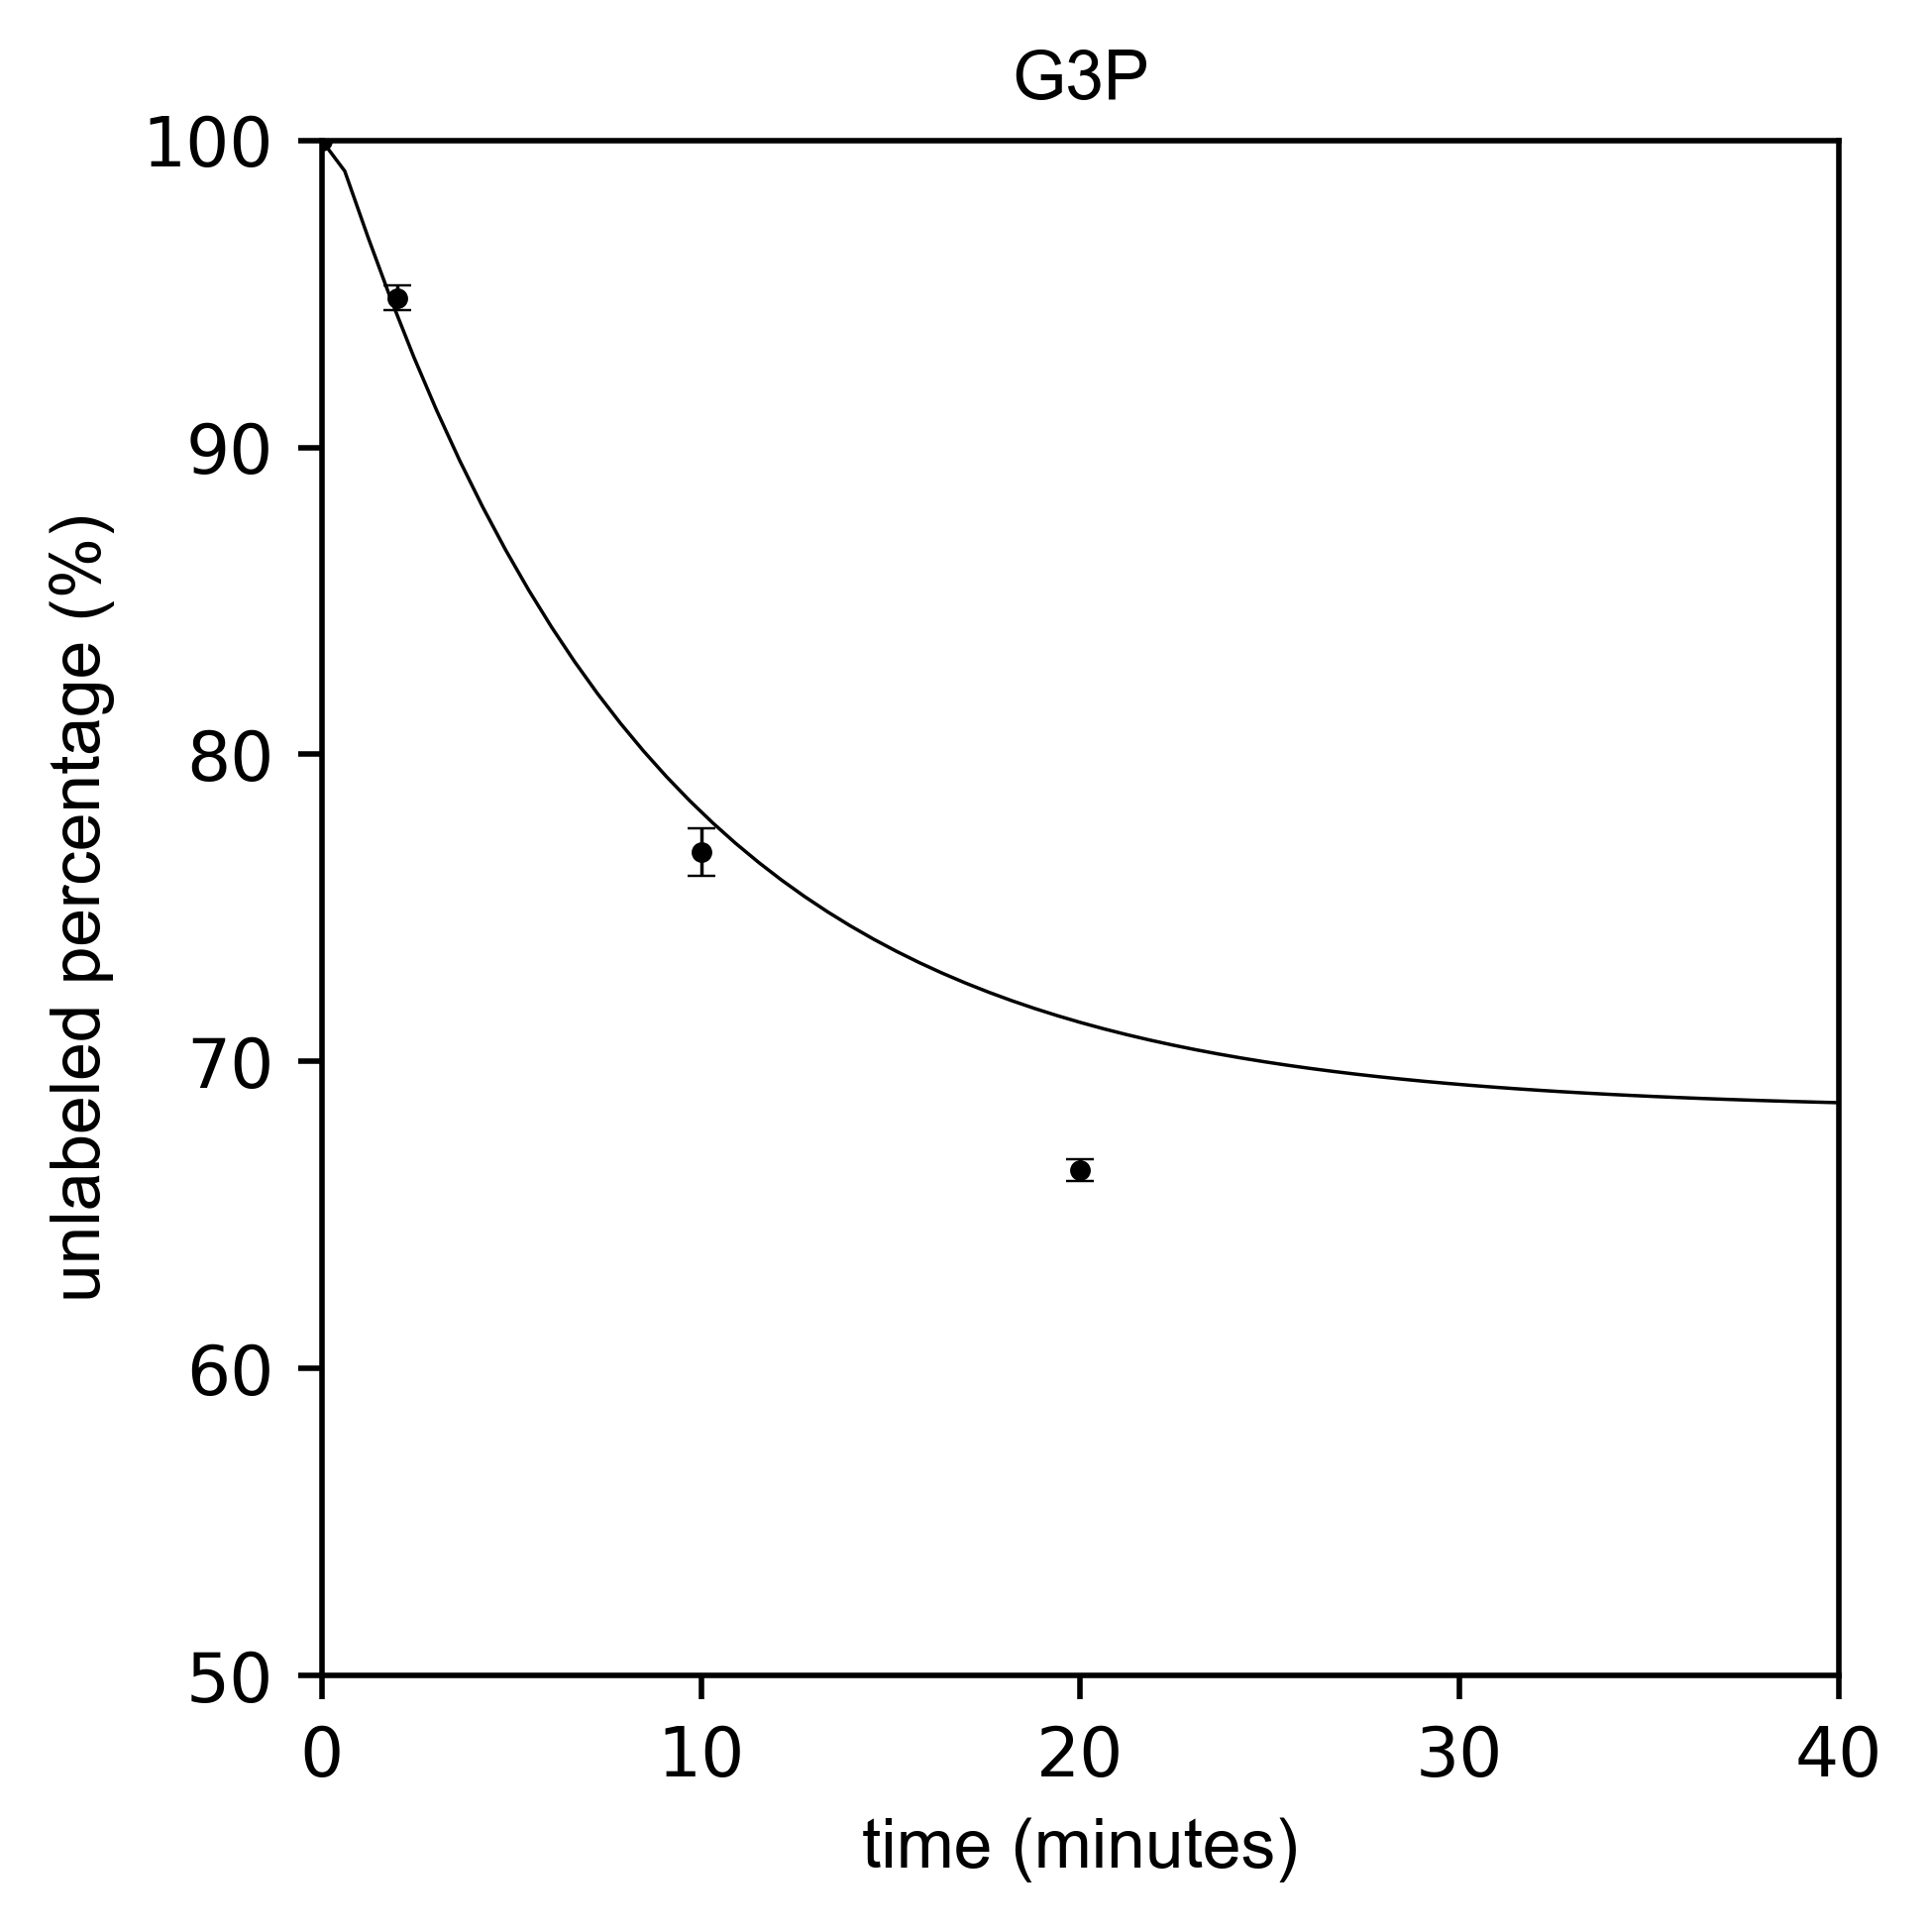

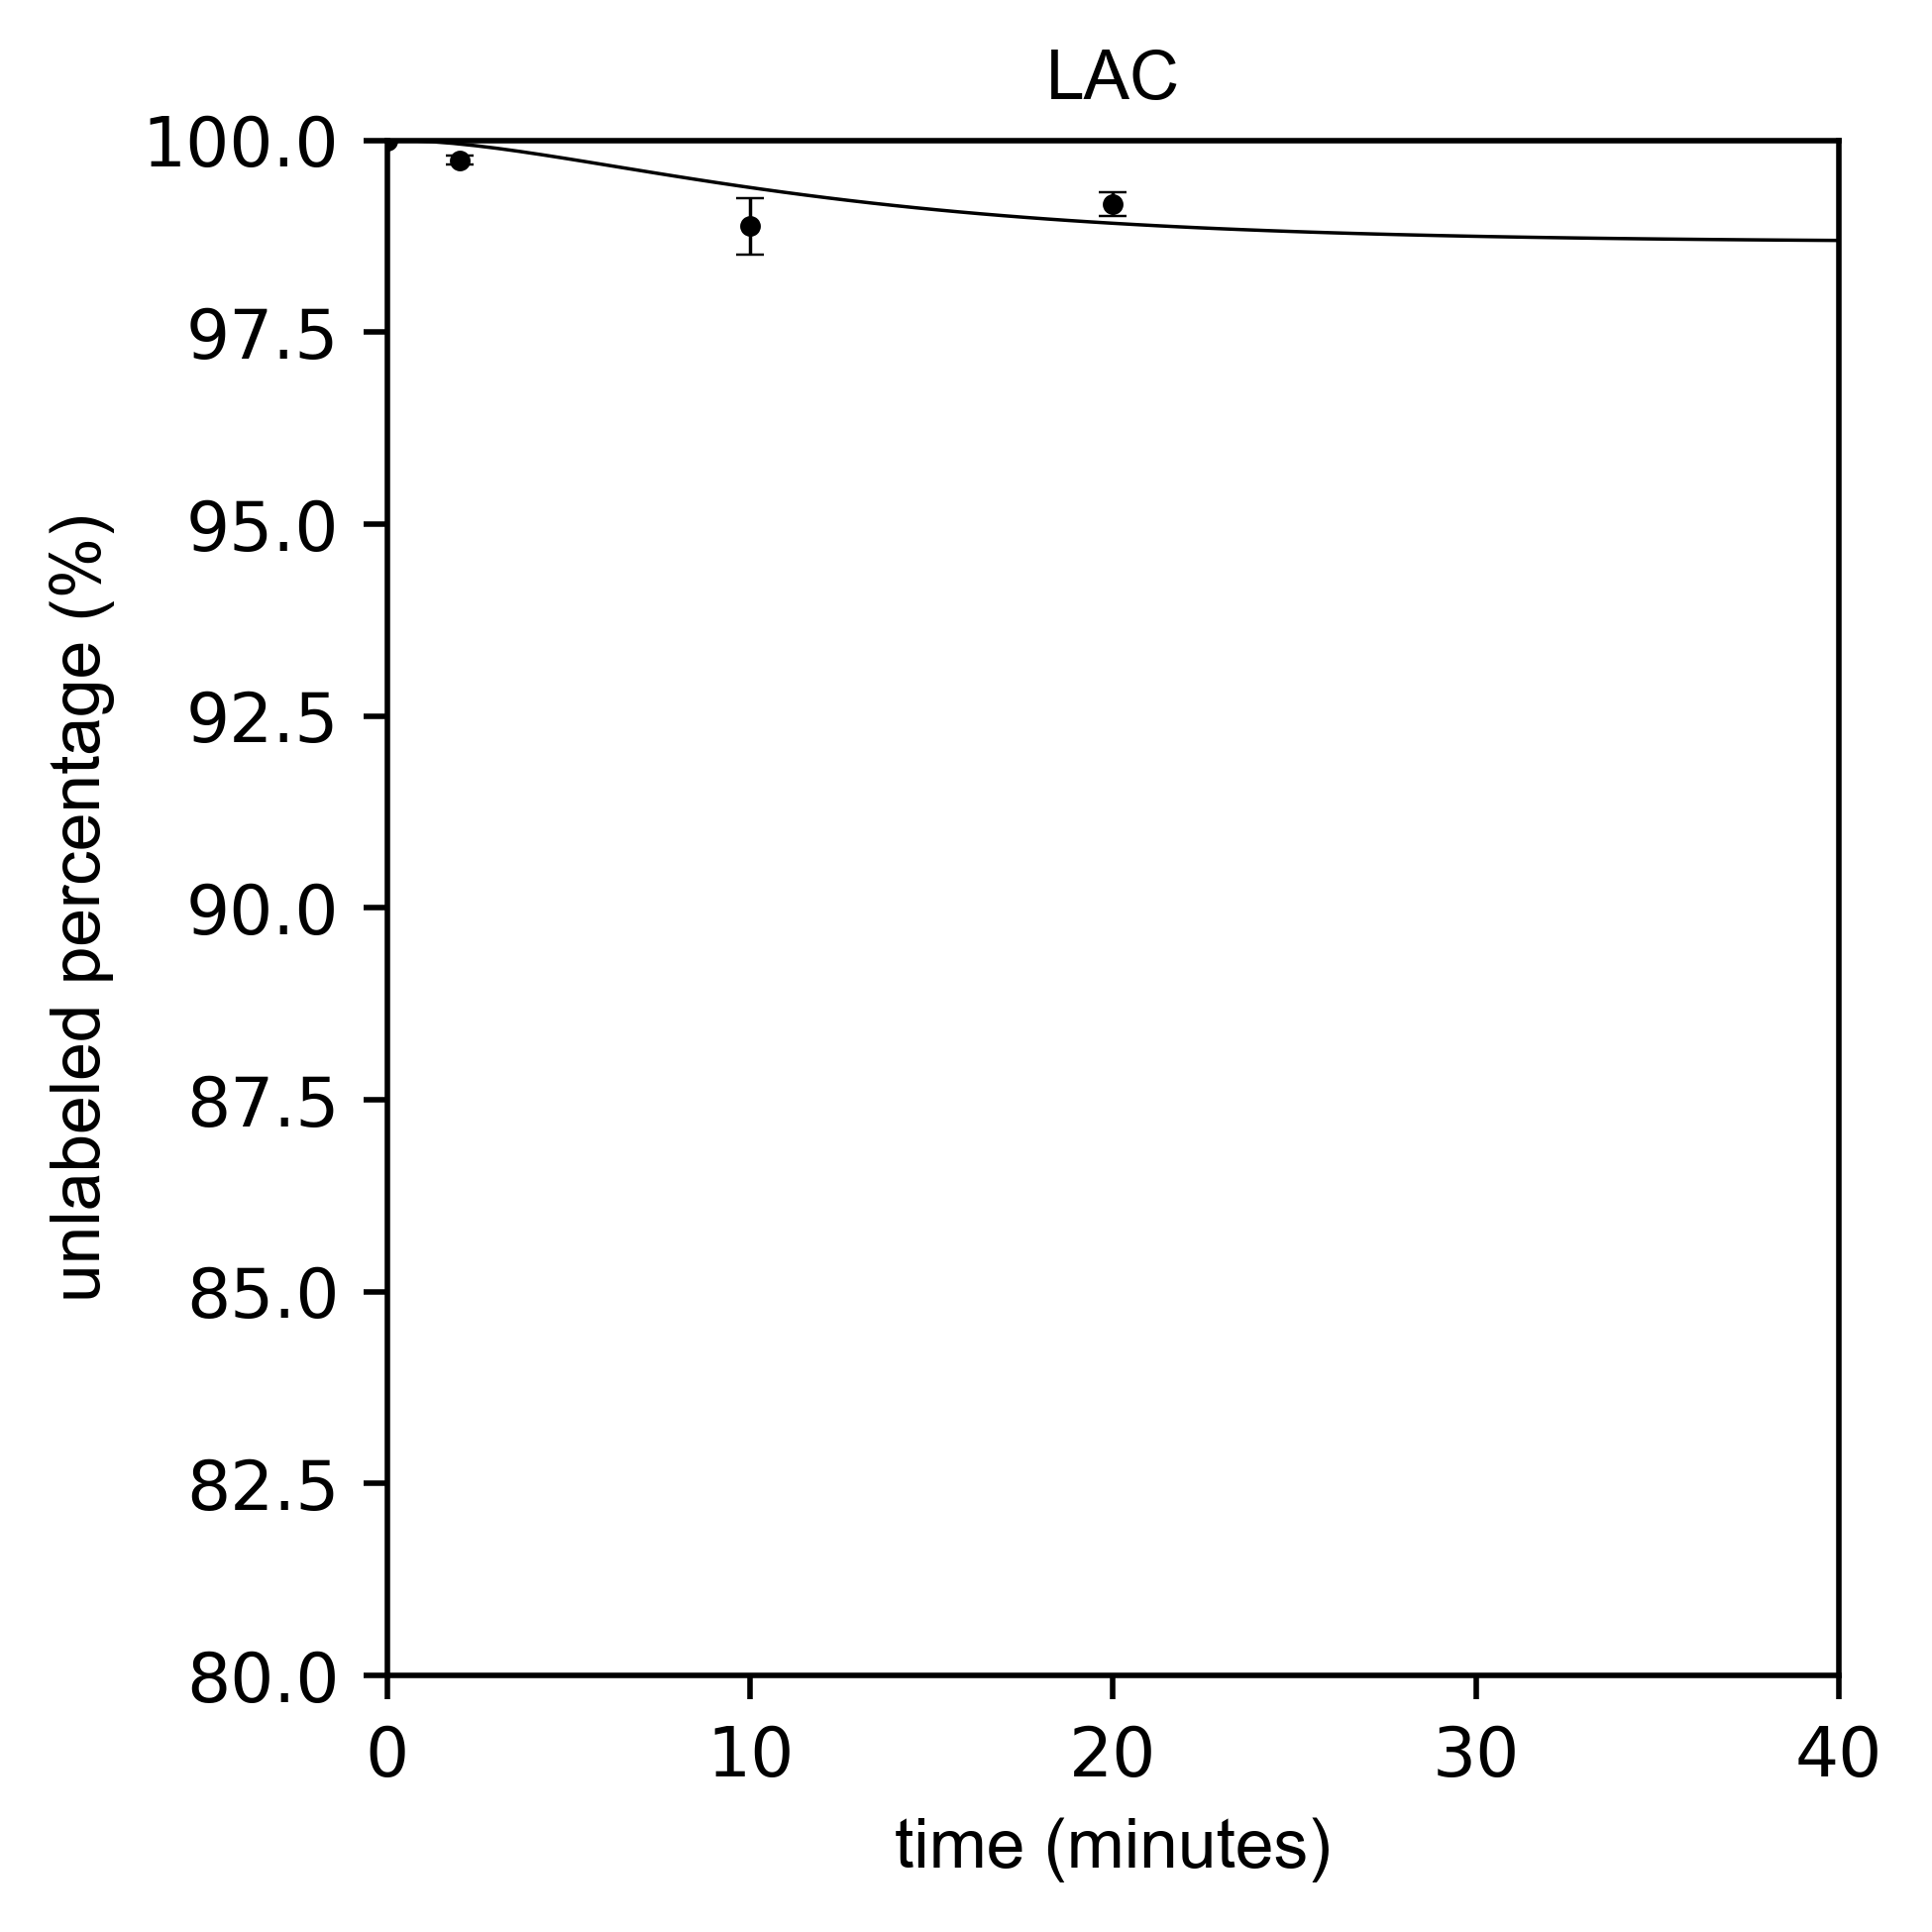

In [14]:
names = ["Glyceraldehyde 3 Phosphate","MAS","G3P","LAC"]


uniqueTs = list(set(t))
uniqueTs.sort()
pp = PdfPages("../data/" + cellType + "/" + cellType + '.pdf')
limits = [(70,100),(50,100),(80,100)]
#colors = ["Grey","dodgerblue","Red"]
for x in range(len(p[0])-1):
  data2Plot = {tt:[] for tt in uniqueTs}
  for tt,ll in zip(t,p[:,x+1]):
        data2Plot[tt].append(ll)
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt]) for tt in uniqueTs] 
  fig = plt.figure(figsize=(4,4))
  
  print(intervalParams[x])
  integrateLabelingModel(t_t,intervalParams[x][0][:3],conc,intervalParams[x][0][5:],intervalParams[x][0][3:5])
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color="black",capthick=.35,markersize=2,elinewidth=.50)
  plt.plot(t_t,[100*i for i in predictedL[:,x+1]],label=names[x+1],color="black",linewidth=.50)
 
  plt.xlabel("time (minutes)",fontname="Arial",fontsize=10)
  plt.ylabel("unlabeled percentage (%)",fontsize = 10,fontname = "Arial")
  #plt.title(names[x+1] + " Flux = " + str(np.round(bestParams[x],2)) + " 95% CI = [" + str(np.round(interval[x][0],2))+ "," + str(np.round(interval[x][1],2)) + "]")
  plt.title(names[x+1],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
  pp.savefig(fig)

pp.close()
plt.show()


In [11]:
# delta = .001
# for f,i in zip(bestParams[:-1],range(len(bestParams[:-1]))):
#     x0 = predictedL
#     tempFlux = list(bestParams)
#     tempFlux[i] += delta*tempFlux[i]
#     integrateLabelingModel(t_t,bestParams[:3],np.append(conc[:-1],bestParams[5:6]),bestParams[6:-1],bestParams[3:5])
#     x1 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     tempFlux = list(bestParams)
#     tempFlux[i] -= delta*tempFlux[i]
#     x2 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     diff1 = np.abs(np.subtract(x0,x1))
#     diff2 = np.abs(np.subtract(x0,x2))
#     diff = (diff1 + diff2)/2
#     diff = np.sum(diff)/diff.size
#     sensitivity = diff/(delta*tempFlux[i])
#     print(sensitivity)